# IMPORT STATEMENTS

In [1]:
!TMPDIR=/home/mgill/ pip install --cache-dir=/home/mgill/ --build /home/mgill/ pandas numpy sklearn xgboost matplotlib tensorflow==2.1.0 keras==2.2.4 fastai python-dateutil scikit-optimize scikit-learn==0.21 graphviz

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.regularizers import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
#from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation
from math import sqrt
from statistics import mean
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc
import skopt
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV
import pickle
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.impute import SimpleImputer

2.1.0
2.2.4


Using TensorFlow backend.


# Load in Data, Prepare OHE, Prepare Main Data

In [3]:
#delete the 2 phenos in the files
#only 3 samples, won't create an accurate model, so its better to treat it as a binary classification
def del_2(vcf, pheno):
    i = 0
    rm_idx = []
    print(pheno.shape)
    print(vcf.shape)
    while (i < pheno.shape[0]):
        if (pheno[i] == 2.0):
            print("found 2")
            rm_idx.append(i)
        i = i + 1
    pheno = np.delete(pheno, rm_idx, 0)
    vcf = vcf.drop((vcf.index[rm_idx]))
    print(pheno.shape)
    print(vcf.shape)
    return vcf, pheno

In [4]:
def new_prep_data(tt_file, ho_file):
    imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
    my_list = []
    x = 0 
    for chunk in pd.read_csv(tt_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            tt_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(tt_pheno.shape)
            tt_pheno = np.reshape(tt_pheno,(len(tt_pheno),1))
            print(tt_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    tt_vcf = pd.concat(my_list, axis = 1)
    my_list = []
    x=0
    for chunk in pd.read_csv(ho_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            ho_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(ho_pheno.shape)
            ho_pheno = np.reshape(ho_pheno,(len(ho_pheno),1))
            print(ho_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    ho_vcf = pd.concat(my_list, axis = 1)
    tt_vcf,tt_pheno = del_2(tt_vcf, tt_pheno)
    ho_vcf,ho_pheno = del_2(ho_vcf, ho_pheno)
    print(tt_vcf.shape)
    print(ho_vcf.shape)
    print(tt_pheno.shape)
    print(ho_pheno.shape)
    return tt_vcf, ho_vcf, tt_pheno, ho_pheno

In [5]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("PuD_Merged_filtered.csv_train_testQTL_SNPS.csv", "PuD_Merged_filtered.csv_holdoutQTL_SNPS.csv")

(617,)
(617, 1)
10000
(155,)
(155, 1)
10000
(617, 1)
(617, 9258)
found 2
found 2
(615, 1)
(615, 9258)
(155, 1)
(155, 9258)
found 2
(154, 1)
(154, 9258)
(615, 9258)
(154, 9258)
(615, 1)
(154, 1)


In [6]:
#only if it hasn't been done yet otherweise skip to load
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe = ohe.fit(tt_vcf)

In [7]:
pickle.dump(ohe, open("PuD_QTL_ohe.dat", "wb"))

In [8]:
#if need or have new holdout data etc.
ohe = pickle.load(open("PuD_QTL_ohe.dat", "rb"))

In [9]:
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(615, 9258)
(615, 27061)
(154, 9258)
(154, 27061)


In [10]:
def find_snp_from_header(ohe,snp_num):
    count = 0
    snp = "Not found"
    found = False
    i = 0
    while i < len(ohe.categories_) and (found == False):
        j = 0
        while j < len(ohe.categories_[i]):
            if(count == snp_num):
                snp = ohe.categories_[i][j]
                found = True
                break
            count = count + 1
            j = j + 1
        i = i + 1
    return snp

In [11]:
## TESTING IF IT WORKS
my_snp = find_snp_from_header(ohe, 10805)
print(my_snp)

T/T


# XGBoost ML Model

### Importing the model building data, one hot encoding and creating a label set

In [12]:
#for optimising the parameters, dont need to run if going straight to k-fold eval
print(tt_vcf.shape)
print(tt_pheno.shape)
seed = randint(0,5000)
X_train, X_test, y_train, y_test = train_test_split(tt_vcf, tt_pheno, test_size=0.2, random_state=seed)
print(X_test.shape)
print(X_train.shape)
print("seed is " + str(seed))

(615, 27061)
(615, 1)
(123, 27061)
(492, 27061)
seed is 4793


# Setting Space to Optimise

In [13]:

space ={'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 10),
        'max_depth': Integer(0, 50),
        'max_delta_step': Integer(0, 20),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'min_child_weight': Integer(0, 5),
        'n_estimators': Integer(50, 200),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')}

# Stops the optimising if above 98% accuracy

In [14]:
def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = xgb_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

# Look for optimium parameters from the defined space and print best params

In [15]:
xgbcl = xgb.XGBClassifier()
xgb_bayes_search = BayesSearchCV(xgbcl, space, n_iter=32, # specify how many iterations
                                    scoring=None, n_jobs=1, cv=5, verbose=3, random_state=42, n_points=12,
                                 refit=True)
xgb_bayes_search.fit(X_train, y_train.ravel(), callback = on_step)
print(xgb_bayes_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:41:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.192, total=   5.6s
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[15:41:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.192, total=   5.4s
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 
[15:41:11] WARNING: ..

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.194, total=   3.1s
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 
[15:41:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_byleve

[CV]  colsample_bylevel=0.25617325301227906, colsample_bytree=0.7083937150495909, gamma=2.41812432168581e-07, learning_rate=0.13965555720269418, max_delta_step=10, max_depth=27, min_child_weight=1, n_estimators=76, reg_alpha=3.178148842971562e-08, reg_lambda=0.005381781269387993, scale_pos_weight=0.23835043249575294, subsample=0.9559763235078597, score=0.909, total=   1.9s
[CV] colsample_bylevel=0.25617325301227906, colsample_bytree=0.7083937150495909, gamma=2.41812432168581e-07, learning_rate=0.13965555720269418, max_delta_step=10, max_depth=27, min_child_weight=1, n_estimators=76, reg_alpha=3.178148842971562e-08, reg_lambda=0.005381781269387993, scale_pos_weight=0.23835043249575294, subsample=0.9559763235078597 
[15:41:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=

[CV]  colsample_bylevel=0.9132100359267209, colsample_bytree=0.7679711803126804, gamma=2.428808912219129e-07, learning_rate=0.03511167856740689, max_delta_step=3, max_depth=8, min_child_weight=4, n_estimators=197, reg_alpha=0.023358352781682152, reg_lambda=2.1396512525873352e-07, scale_pos_weight=0.001760608876847004, subsample=0.15990388740095085, score=0.192, total=   4.2s
[CV] colsample_bylevel=0.9132100359267209, colsample_bytree=0.7679711803126804, gamma=2.428808912219129e-07, learning_rate=0.03511167856740689, max_delta_step=3, max_depth=8, min_child_weight=4, n_estimators=197, reg_alpha=0.023358352781682152, reg_lambda=2.1396512525873352e-07, scale_pos_weight=0.001760608876847004, subsample=0.15990388740095085 
[15:42:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_byle

[CV]  colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, scale_pos_weight=0.4420166988445819, subsample=0.037978567417966985, score=0.888, total=   2.3s
[CV] colsample_bylevel=0.3173884684879576, colsample_bytree=0.9154083808190769, gamma=0.37957777315906627, learning_rate=0.046564465205051725, max_delta_step=5, max_depth=25, min_child_weight=4, n_estimators=98, reg_alpha=1.8932210348902655e-05, reg_lambda=10.393593598030753, scale_pos_weight=0.019183460268621746, subsample=0.6299477217301774 
[15:42:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.31

[CV]  colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.7439751766594195e-06, scale_pos_weight=1.6287615199535114e-06, subsample=0.9872483677632868, score=0.194, total=   2.9s
[CV] colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.7439751766594195e-06, scale_pos_weight=1.6287615199535114e-06, subsample=0.9872483677632868 
[15:43:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_byle

[CV]  colsample_bylevel=0.1798648261515349, colsample_bytree=0.1536154650973617, gamma=2.692171045057089e-07, learning_rate=0.031045751168128115, max_delta_step=12, max_depth=24, min_child_weight=3, n_estimators=113, reg_alpha=0.0011518554964803237, reg_lambda=3.9270934206560135e-05, scale_pos_weight=0.036328353682153036, subsample=0.5123744729843144, score=0.194, total=   1.8s
[CV] colsample_bylevel=0.1798648261515349, colsample_bytree=0.1536154650973617, gamma=2.692171045057089e-07, learning_rate=0.031045751168128115, max_delta_step=12, max_depth=24, min_child_weight=3, n_estimators=113, reg_alpha=0.0011518554964803237, reg_lambda=3.9270934206560135e-05, scale_pos_weight=0.036328353682153036, subsample=0.5123744729843144 
[15:43:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsampl

[CV]  colsample_bylevel=0.88542798001491, colsample_bytree=0.15107725561517718, gamma=0.09274068410384222, learning_rate=0.11437510345794359, max_delta_step=0, max_depth=6, min_child_weight=5, n_estimators=200, reg_alpha=1.2952579279714691e-08, reg_lambda=0.45707493844512304, scale_pos_weight=10.561837873121673, subsample=0.9105119208713889, score=0.899, total=   3.5s
[CV] colsample_bylevel=0.88542798001491, colsample_bytree=0.15107725561517718, gamma=0.09274068410384222, learning_rate=0.11437510345794359, max_delta_step=0, max_depth=6, min_child_weight=5, n_estimators=200, reg_alpha=1.2952579279714691e-08, reg_lambda=0.45707493844512304, scale_pos_weight=10.561837873121673, subsample=0.9105119208713889 
[15:43:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.88542798

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.1min finished


best score: 0.8922764227642277
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=0.06827503415025202, colsample_bytree=0.01, gamma=6.201646382342046e-08, learning_rate=0.17446474110118035, max_delta_step=0, max_depth=38, min_child_weight=5, n_estimators=50, reg_alpha=0.1130106780220491, reg_lambda=2.620738670142872e-06, scale_pos_weight=0.9869705414087024, subsample=0.2202398046751133 
[15:44:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bylevel=0.06827503415025202, colsample_bytree=0.01, gamma=6.201646382342046e-08, learning_rate=0.17446474110118035, max_delta_step=0, max_depth=38, min_child_weight=5, n_estimators=50, reg_alpha=0.1130106780220491, reg_lambda=2.620738670142872e-06, scale_pos_weight=0.9869705414087024, subsample=0.2202398046751133, score=0.859, total=   1.0s
[CV] colsample_bylevel=0.06827503415025202, colsample_bytree=0.01, gamma=6.201646382342046e-08, learning_rate=0.17446474110118035, max_delta_step=0, max_depth=38, min_child_weight=5, n_estimators=50, reg_alpha=0.1130106780220491, reg_lambda=2.620738670142872e-06, scale_pos_weight=0.9869705414087024, subsample=0.2202398046751133 
[15:44:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  colsample_bylevel=0.06827503415025202, colsample_bytree=0.01, gamma=6.201646382342046e-08, learning_rate=0.17446474110118035, max_delta_step=0, max_depth=38, min_child_weight=5, n_estimators=50, reg_alpha=0.1130106780220491, reg_lambda=2.620738670142872e-06, scale_pos_weight=0.9869705414087024, subsample=0.2202398046751133, score=0.899, total=   1.0s
[CV] colsample_bylevel=0.06827503415025202, colsample_bytree=0.01, gamma=6.201646382342046e-08, learning_rate=0.17446474110118035, max_delta_step=0, max_depth=38, min_child_weight=5, n_estimators=50, reg_alpha=0.1130106780220491, reg_lambda=2.620738670142872e-06, scale_pos_weight=0.9869705414087024, subsample=0.2202398046751133 
[15:44:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV]  colsample_bylevel=0.06827503415025202, colsample_bytree=0.01, gamma=6.201646382342046e-08, learning_rate=0.17446474110118035, max_delta_step=0, max_depth=38, min_child_weight=5, n_estimators=50, reg_alpha=0.1130106780220491, reg_lambda=2.620738670142872e-06, scale_pos_weight=0.9869705414087024, subsample=0.2202398046751133, score=0.847, total=   1.2s
[CV] colsample_bylevel=0.06827503415025202, colsample_bytree=0.01, gamma=6.201646382342046e-08, learning_rate=0.17446474110118035, max_delta_step=0, max_depth=38, min_child_weight=5, n_estimators=50, reg_alpha=0.1130106780220491, reg_lambda=2.620738670142872e-06, scale_pos_weight=0.9869705414087024, subsample=0.2202398046751133 
[15:44:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.06827503415025202, colsample_byt

[CV]  colsample_bylevel=0.7644483441463623, colsample_bytree=0.01, gamma=0.0002205228508088852, learning_rate=0.8207368438419831, max_delta_step=0, max_depth=32, min_child_weight=5, n_estimators=116, reg_alpha=1.0, reg_lambda=0.024443959049826852, scale_pos_weight=499.99999999999994, subsample=0.6589435102986304, score=0.838, total=   1.9s
[CV] colsample_bylevel=0.7644483441463623, colsample_bytree=0.01, gamma=0.0002205228508088852, learning_rate=0.8207368438419831, max_delta_step=0, max_depth=32, min_child_weight=5, n_estimators=116, reg_alpha=1.0, reg_lambda=0.024443959049826852, scale_pos_weight=499.99999999999994, subsample=0.6589435102986304 
[15:44:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.7644483441463623, colsample_bytree=0.01, gamma=0.00022052285080888

[CV]  colsample_bylevel=0.5159500334864179, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=0.6719562479839406, max_delta_step=0, max_depth=21, min_child_weight=5, n_estimators=50, reg_alpha=1.0, reg_lambda=0.04987064846940078, scale_pos_weight=129.85621922306987, subsample=0.01, score=0.808, total=   1.0s
[CV] colsample_bylevel=0.5159500334864179, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=0.6719562479839406, max_delta_step=0, max_depth=21, min_child_weight=5, n_estimators=50, reg_alpha=1.0, reg_lambda=0.04987064846940078, scale_pos_weight=129.85621922306987, subsample=0.01 
[15:44:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.5159500334864179, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=0.6719562479839406, 

[CV]  colsample_bylevel=0.01, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.5907440003962897, max_delta_step=0, max_depth=0, min_child_weight=2, n_estimators=50, reg_alpha=1.0, reg_lambda=1.61128747307602e-07, scale_pos_weight=499.99999999999994, subsample=0.011858625638756174, score=0.808, total=   1.0s
[CV] colsample_bylevel=0.01, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.5907440003962897, max_delta_step=0, max_depth=0, min_child_weight=2, n_estimators=50, reg_alpha=1.0, reg_lambda=1.61128747307602e-07, scale_pos_weight=499.99999999999994, subsample=0.011858625638756174 
[15:45:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.01, colsample_bytree=0.01, gamma=1e-09, learning_rate=0.5907440003962897, max_delta_step=0, max_depth=0, min_child_weight=2, n

[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1.3770078283915654e-08, learning_rate=0.1004585822069077, max_delta_step=20, max_depth=0, min_child_weight=0, n_estimators=200, reg_alpha=1e-09, reg_lambda=14.305009068676906, scale_pos_weight=5.525013305034832, subsample=1.0, score=0.808, total=   4.5s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1.3770078283915654e-08, learning_rate=0.1004585822069077, max_delta_step=20, max_depth=0, min_child_weight=0, n_estimators=200, reg_alpha=1e-09, reg_lambda=14.305009068676906, scale_pos_weight=5.525013305034832, subsample=1.0 
[15:45:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1.3770078283915654e-08, learning_rate=0.1004585822069077, max_delta_step=20, max_depth=0, min_chi

[CV]  colsample_bylevel=0.01, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=20, max_depth=0, min_child_weight=5, n_estimators=50, reg_alpha=1e-09, reg_lambda=46.85025938470161, scale_pos_weight=35.21313331296706, subsample=0.01, score=0.806, total=   1.0s
[CV] colsample_bylevel=0.01, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=20, max_depth=0, min_child_weight=5, n_estimators=50, reg_alpha=1e-09, reg_lambda=46.85025938470161, scale_pos_weight=35.21313331296706, subsample=0.01 
[15:46:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.01, colsample_bytree=1.0, gamma=1e-09, learning_rate=1.0, max_delta_step=20, max_depth=0, min_child_weight=5, n_estimators=50, reg_alpha=1e-09, reg_lambda=46.85025938470161, scale_pos_weight=3

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.0min finished


best score: 0.8922764227642277
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] colsample_bylevel=0.32952260024826985, colsample_bytree=0.06043227642193734, gamma=1.3076804628164894e-06, learning_rate=0.15844528454152426, max_delta_step=0, max_depth=35, min_child_weight=2, n_estimators=148, reg_alpha=1e-09, reg_lambda=4.810314289380104, scale_pos_weight=0.3665043935813407, subsample=1.0 
[15:46:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bylevel=0.32952260024826985, colsample_bytree=0.06043227642193734, gamma=1.3076804628164894e-06, learning_rate=0.15844528454152426, max_delta_step=0, max_depth=35, min_child_weight=2, n_estimators=148, reg_alpha=1e-09, reg_lambda=4.810314289380104, scale_pos_weight=0.3665043935813407, subsample=1.0, score=0.909, total=   2.9s
[CV] colsample_bylevel=0.32952260024826985, colsample_bytree=0.06043227642193734, gamma=1.3076804628164894e-06, learning_rate=0.15844528454152426, max_delta_step=0, max_depth=35, min_child_weight=2, n_estimators=148, reg_alpha=1e-09, reg_lambda=4.810314289380104, scale_pos_weight=0.3665043935813407, subsample=1.0 
[15:46:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  colsample_bylevel=0.32952260024826985, colsample_bytree=0.06043227642193734, gamma=1.3076804628164894e-06, learning_rate=0.15844528454152426, max_delta_step=0, max_depth=35, min_child_weight=2, n_estimators=148, reg_alpha=1e-09, reg_lambda=4.810314289380104, scale_pos_weight=0.3665043935813407, subsample=1.0, score=0.919, total=   2.9s
[CV] colsample_bylevel=0.32952260024826985, colsample_bytree=0.06043227642193734, gamma=1.3076804628164894e-06, learning_rate=0.15844528454152426, max_delta_step=0, max_depth=35, min_child_weight=2, n_estimators=148, reg_alpha=1e-09, reg_lambda=4.810314289380104, scale_pos_weight=0.3665043935813407, subsample=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[15:46:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.32952260024826985, colsample_bytree=0.06043227642193734, gamma=1.3076804628164894e-06, learning_rate=0.15844528454152426, max_delta_step=0, max_depth=35, min_child_weight=2, n_estimators=148, reg_alpha=1e-09, reg_lambda=4.810314289380104, scale_pos_weight=0.3665043935813407, subsample=1.0, score=0.867, total=   2.7s
[CV] colsample_bylevel=0.32952260024826985, colsample_bytree=0.06043227642193734, gamma=1.3076804628164894e-06, learning_rate=0.15844528454152426, max_delta_step=0, max_depth=35, min_child_weight=2, n_estimators=148, reg_alpha=1e-09, reg_lambda=4.810314289380104, scale_pos_weight=0.3665043935813407, subsample=1.0 
[15:46:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evalu

[CV]  colsample_bylevel=0.35741069051885505, colsample_bytree=1.0, gamma=2.178932790999233e-07, learning_rate=0.01, max_delta_step=4, max_depth=47, min_child_weight=2, n_estimators=50, reg_alpha=4.3879979044321935e-08, reg_lambda=1000.0, scale_pos_weight=0.0001303927919489785, subsample=1.0, score=0.192, total=   1.9s
[CV] colsample_bylevel=0.35741069051885505, colsample_bytree=1.0, gamma=2.178932790999233e-07, learning_rate=0.01, max_delta_step=4, max_depth=47, min_child_weight=2, n_estimators=50, reg_alpha=4.3879979044321935e-08, reg_lambda=1000.0, scale_pos_weight=0.0001303927919489785, subsample=1.0 
[15:46:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.35741069051885505, colsample_bytree=1.0, gamma=2.178932790999233e-07, learning_rate=0.01, max_delta_step=4, ma

[CV]  colsample_bylevel=0.8334188356048486, colsample_bytree=0.44042004571838084, gamma=3.305283648712307e-05, learning_rate=0.06782508534975051, max_delta_step=6, max_depth=13, min_child_weight=3, n_estimators=127, reg_alpha=7.603252202420129e-06, reg_lambda=0.004819075740673885, scale_pos_weight=0.2765835986785136, subsample=1.0, score=0.909, total=   3.1s
[CV] colsample_bylevel=0.8334188356048486, colsample_bytree=0.44042004571838084, gamma=3.305283648712307e-05, learning_rate=0.06782508534975051, max_delta_step=6, max_depth=13, min_child_weight=3, n_estimators=127, reg_alpha=7.603252202420129e-06, reg_lambda=0.004819075740673885, scale_pos_weight=0.2765835986785136, subsample=1.0 
[15:47:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.8334188356048486, colsample_

[CV]  colsample_bylevel=0.7351685882237311, colsample_bytree=0.6282173601611164, gamma=0.021280254429092534, learning_rate=0.03501061593379533, max_delta_step=13, max_depth=41, min_child_weight=1, n_estimators=200, reg_alpha=1e-09, reg_lambda=0.0001728372112897385, scale_pos_weight=6.872297570550146e-05, subsample=0.01, score=0.194, total=   5.9s
[CV] colsample_bylevel=0.6786079903997393, colsample_bytree=0.5904296003940921, gamma=0.000908694416474599, learning_rate=0.07049744363189675, max_delta_step=12, max_depth=46, min_child_weight=2, n_estimators=138, reg_alpha=6.324048435929487e-05, reg_lambda=17.1004858577675, scale_pos_weight=9.263806022187338e-05, subsample=0.3631219774028291 
[15:47:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.6786079903997393, colsample

[CV]  colsample_bylevel=0.6126118258298363, colsample_bytree=0.046176404743748685, gamma=1.0634094096078316e-09, learning_rate=0.19091804791137235, max_delta_step=0, max_depth=50, min_child_weight=3, n_estimators=164, reg_alpha=0.0005190953070978562, reg_lambda=0.05762564927505769, scale_pos_weight=0.28391869110500917, subsample=1.0, score=0.898, total=   3.1s
[CV] colsample_bylevel=0.6126118258298363, colsample_bytree=0.046176404743748685, gamma=1.0634094096078316e-09, learning_rate=0.19091804791137235, max_delta_step=0, max_depth=50, min_child_weight=3, n_estimators=164, reg_alpha=0.0005190953070978562, reg_lambda=0.05762564927505769, scale_pos_weight=0.28391869110500917, subsample=1.0 
[15:48:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bylevel=0.6126118258298363, colsam

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.0min finished


best score: 0.8963414634146342
[15:48:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


OrderedDict([('colsample_bylevel', 0.32952260024826985), ('colsample_bytree', 0.06043227642193734), ('gamma', 1.3076804628164894e-06), ('learning_rate', 0.15844528454152426), ('max_delta_step', 0), ('max_depth', 35), ('min_child_weight', 2), ('n_estimators', 148), ('reg_alpha', 1e-09), ('reg_lambda', 4.810314289380104), ('scale_pos_weight', 0.3665043935813407), ('subsample', 1.0)])


# Take Best Model from the Optimisation

In [17]:
#either print out from the optimisation or run the ordered dict.
#print(xgb_bayes_search.best_params_)
best_params = OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 1.0), ('gamma', 0.07059904760306446), ('learning_rate', 0.011073929920126888), ('max_delta_step', 20), ('max_depth', 29), ('min_child_weight', 4), ('n_estimators', 52), ('reg_alpha', 1e-09), ('reg_lambda', 1000.0), ('scale_pos_weight', 0.2860271078350677), ('subsample', 1.0)])

In [ ]:
model = xgb.XGBClassifier(**xgb_bayes_search.best_params_)

In [ ]:
model.fit(X_train, y_train.ravel(), verbose=True)

# Use this model to predict the test set and evaluate

In [ ]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
#sees how accurate the model was when testing the test set
accuracy = accuracy_score(y_test, predictions)
pcent = accuracy * 100.0
print("The accuracy of this model is" + str(pcent))
xgb_predictions = model.predict(X_test)
xgb_probs = model.predict_proba(X_test)[:, 1]

In [5]:
#Evaluation Function to create ROC Score and AUROC Graph
#from matplotlib.pyplot import figure
#figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
def evaluate_model(predictions, probs, y_pheno):
   #Computes statistics and shows ROC curve.
    
    results = {}
    
    results['recall'] = recall_score(y_pheno, predictions)
    results['precision'] = precision_score(y_pheno, predictions)
    results['roc'] = roc_auc_score(y_pheno, probs)
    my_roccy = ("(ROC SCORE: %.2f)" % (roc_auc_score(y_pheno, probs)))
    
    # Calculate false positive rates and true positive rates
    model_fpr, model_tpr, _ = roc_curve(y_pheno, probs)
    return model_fpr, model_tpr, my_roccy

    #plt.figure(figsize = (8, 6))
   # plt.rcParams['font.size'] = 16
    
    # Plot both curves
   # plt.plot(model_fpr, model_tpr, 'r', label = 'Holdout Data'+my_roccy)
   # plt.legend();
   # plt.xlabel('False Positive Rate'); 
   # plt.ylabel('True Positive Rate'); plt.title('AUROC Curve for Xgboost Classification of Flower Colour');
   # plt.show();

In [ ]:
evaluate_model(xgb_predictions, xgb_probs)

# 10-fold cross validation on training / holdout data, evaluation and AUROC

# Creating Model from best parameters and then evaluating

In [6]:
def eval_k_fold(m, x, y, k, hx, hy):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    fig1 = plt.figure(figsize=[12,12])

    tprs = []
    aucs = []
    results = []
    mean_fpr = np.linspace(0,1,100)
    high = 0
    best = m
    i = 1
    for train,test in cv.split(x,y):
        prediction = m.fit(x[train],y[train].ravel()).predict_proba(x[test])
        print("variables for auroc curve done. Processing fold accuracy + checking best model")
        y_pred = m.predict(x[test])
        predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        accuracy = accuracy_score(y[test], predictions)
        pcent = accuracy * 100.0
        print("The accuracy of this model is" + str(pcent))
        if(pcent > high):
            high = pcent
            best = m
        fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        results.append(pcent)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
    
    holdout_pred = best.predict(hx)
    predictions = [round(value) for value in holdout_pred]
    #sees how accurate the model was when testing the test set
    accuracy = accuracy_score(hy, predictions)
    pcent = accuracy * 100.0
    print(pcent)
    xgb_predictions = best.predict(hx)
    xgb_probs = best.predict_proba(hx)[:, 1]
    model_fpr, model_tpr, my_roccy = evaluate_model(xgb_predictions, xgb_probs, hy)
    plt.plot(model_fpr, model_tpr, 'r', label = 'Holdout Data'+my_roccy, lw=2)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Pubescence Density Training Model & Holdout Data')
    plt.legend(loc="lower right")
    plt.show()

    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    print("Holdout Accuracy: %.2f%%" % (pcent))
    
    return best

(615, 27061)
(615, 1)
(154, 27061)
(154, 1)


/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is79.03225806451613


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is93.54838709677419


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is96.7741935483871


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is95.16129032258065


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is83.87096774193549


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is83.60655737704919


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is85.24590163934425


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is85.24590163934425


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is90.1639344262295


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/mgill/.local/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is91.80327868852459
88.31168831168831


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


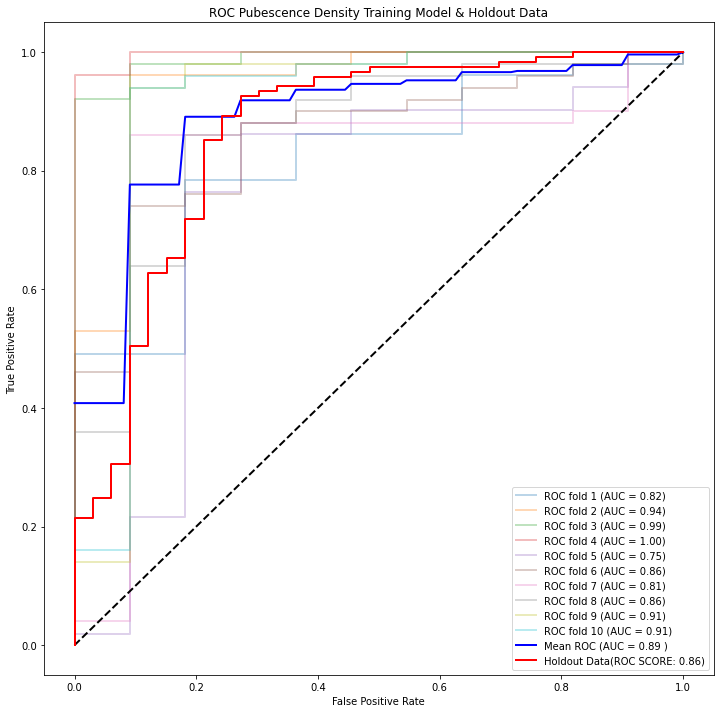

Training Testing Accuracy: 88.45% (5.55%)
Holdout Accuracy: 88.31%


In [19]:
#THESE ARE THE BEST PARAMETERS
best_params = xgb_bayes_search.best_params_
#best_params = OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 1.0), ('gamma', 0.07059904760306446), ('learning_rate', 0.011073929920126888), ('max_delta_step', 20), ('max_depth', 29), ('min_child_weight', 4), ('n_estimators', 52), ('reg_alpha', 1e-09), ('reg_lambda', 1000.0), ('scale_pos_weight', 0.2860271078350677), ('subsample', 1.0)])
#load holdout data
print(tt_vcf.shape)
print(tt_pheno.shape)
print(ho_vcf.shape)
print(ho_pheno.shape)
model_2 = xgb.XGBClassifier(**best_params) #if optimised in same session, other enter manually below
#this function should average out 10 folds and training, with inital params optimised
#average accuracy and std should be calculated along with a nice AUROC graph of train/test models
#best model should be extracted for use on holdout set
best_model = eval_k_fold(model_2, tt_vcf, tt_pheno, 10, ho_vcf, ho_pheno)


# save this model

In [20]:
import pickle
pickle.dump(best_model, open("PuD_kfold_10_XGB_QTL.dat", "wb"))

# load model

In [21]:
#only load if not generated in same session
best_model = pickle.load(open("PuD_kfold_10_XGB_QTL.dat", "rb"))

# SNPS of Importance

<Figure size 1440x1440 with 0 Axes>

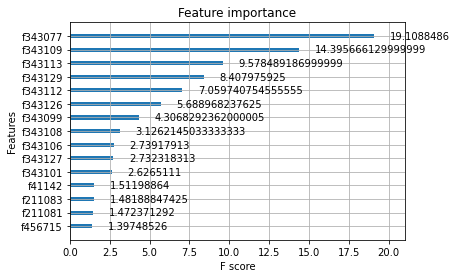

In [33]:
from xgboost import plot_importance
from matplotlib import pyplot
#best_model = pickle.load(open("FC_kfold_10_tt_from_all.pickle.dat", "rb"))
plt.figure(figsize = (20, 20))
plot_importance(best_model, max_num_features=15, importance_type='gain', height=0.3)
pyplot.show()

##WTF???

In [22]:
#This function essentially returns an array of dataframe headers the length of OHE'd input SNPs for training data
#EG. It will be able to determine that feature 357310 is Gm13_17683957 but not what allele it is
#eg. feature 357309 357310 and 357311 may all be one hot encoded versions of all possible values of Gm13_17683957
#iterating through the saved OHE will by able to determine what specific allele the feature is but cannot determine
#what SNP header it belongs to. Therefore combining these two methods you can determine both allele and SNP
snp = []
imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
fs_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
x = 0
n_headers = []
le = LabelEncoder()
#while (i < 10):
for chunk in pd.read_csv("PuD_Merged_filtered.csv_train_testQTL_SNPS.csv", chunksize=10000, index_col="Unnamed: 0"):
    chunk = chunk.T
    if 'Value' in chunk.columns:
        print("dropping value so it doesn't include that in headers")
        chunk = chunk.drop(columns=['Value'])
    headers = chunk.columns
    row_idx = chunk.index
    chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
    #since imputing makes a numpy array have to turn back into PD for label encoding
    chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
    chunk = chunk.apply(lambda col: le.fit_transform(col))
    c_headers = chunk.columns
    y = 0
    for column in chunk:
        d = (chunk[column].nunique())
        n_headers.extend([c_headers[y] for i in range(d)])
        #print(n_headers)
        #print(l)
        #n_headers.append(c_headers[y] * d)
        #print(n_headers)
        y = y + 1
    #to double check that it would indeed be one hot encoded with this amount of columns
    chunk = fs_ohe.fit_transform(chunk)
    x = x + chunk.shape[1]
    print("my X value is: " + str(x))
    print(chunk.shape)
    print("my header list is: " + str(len(n_headers)))
print(len(n_headers))

dropping value so it doesn't include that in headers
my X value is: 27061
(617, 27061)
my header list is: 27061
27061


Gm12_37598781 (T/G)
1
1


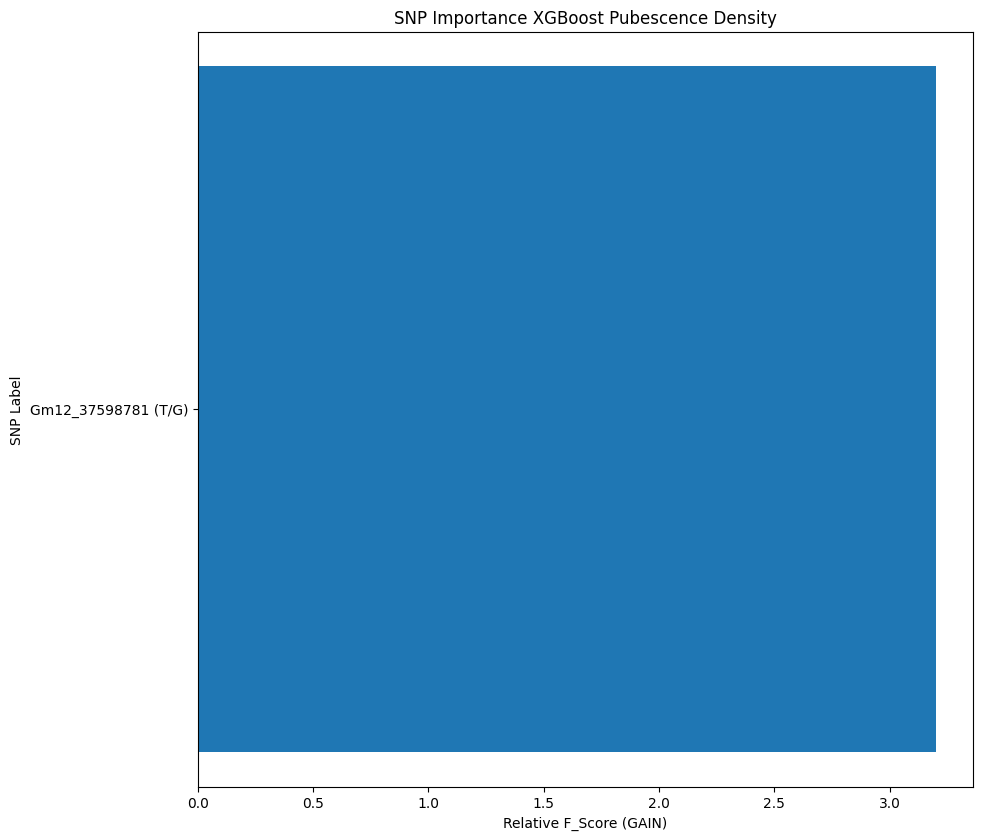

In [35]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
fs = [343112]
scores = [3.2]
snp_label = []
for jj in fs:
    jj_allele = find_snp_from_header(ohe, jj)
    this_snp = (n_headers[jj] + ' ('+str(jj_allele)+')')
    print(this_snp)
    snp_label.append(this_snp)
snp_label.reverse()
scores.reverse()
print(len(scores))
print(len(snp_label))
plt.barh(snp_label,scores)
plt.title('SNP Importance XGBoost Pubescence Density')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

In [23]:
my_dict = best_model.get_booster().get_score(importance_type="gain")

In [11]:
print(my_dict)

{'f343109': 14.395666129999999, 'f211081': 1.472371292, 'f471230': 0.388008118, 'f485559': 0.619194031, 'f287101': 0.348964691, 'f150486': 0.0958331823, 'f468789': 0.8511053706666667, 'f246199': 1.11846352, 'f610468': 0.572887421, 'f299699': 0.138659477, 'f343077': 19.1088486, 'f343108': 3.1262145033333333, 'f230582': 0.113717332, 'f41142': 1.51198864, 'f307076': 0.358388901, 'f553864': 0.37010240549999995, 'f343126': 5.688968237625, 'f1220': 0.0118211508, 'f319274': 0.7404941915000001, 'f303711': 0.381921768, 'f92437': 0.126698971, 'f518819': 1.33851051, 'f41148': 1.1750324145, 'f79408': 0.177440643, 'f456715': 1.39748526, 'f315306': 0.546025753, 'f235321': 0.566467762, 'f612692': 0.17315423505, 'f474594': 1.1300297176666667, 'f471687': 0.95946312, 'f591400': 0.44310379, 'f174041': 0.257955551, 'f136380': 0.1684338, 'f42318': 0.569462776, 'f276733': 0.7903306182500001, 'f621274': 0.448719025, 'f199929': 0.172986031, 'f211083': 1.48188847425, 'f88106': 0.085868597, 'f490731': 0.9504489

In [24]:
def rename_f_header(fn,n_headers,ohe):
    fn = fn[1:]
    fn = int(fn)
    allele = find_snp_from_header(ohe, fn)
    this_snp = (n_headers[fn] + ' ('+str(allele)+')')
    return this_snp

In [25]:
#convert feature to actual SNP name
i = 0
new_dict = {}
for key in my_dict:
    new_key = rename_f_header(key, n_headers, ohe)
    new_dict[new_key] = my_dict[key]
    i = i + 1
    print(str(i))
    if(my_dict):
        continue
    else:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [26]:
new_fi = pd.Series(new_dict)
print(new_fi)
df = new_fi.to_frame()
df = df.rename(columns = {0:'F_Score(GAIN)'})
print(df)

Gm12_37604329 (G/A)    71.051202
Gm08_413808 (T/T)       2.054504
Gm12_37596718 (C/G)    82.083473
Gm12_37597634 (A/A)     2.163986
Gm08_134209 (C/G)       0.384732
                         ...    
Gm12_37218274 (C/T)     0.144848
Gm01_58698804 (G/A)     0.131102
Gm01_58496573 (A/A)     0.123063
Gm12_37601252 (A/A)     0.008376
Gm01_58549713 (T/T)     0.149449
Length: 776, dtype: float64
                     F_Score(GAIN)
Gm12_37604329 (G/A)      71.051202
Gm08_413808 (T/T)         2.054504
Gm12_37596718 (C/G)      82.083473
Gm12_37597634 (A/A)       2.163986
Gm08_134209 (C/G)         0.384732
...                            ...
Gm12_37218274 (C/T)       0.144848
Gm01_58698804 (G/A)       0.131102
Gm01_58496573 (A/A)       0.123063
Gm12_37601252 (A/A)       0.008376
Gm01_58549713 (T/T)       0.149449

[776 rows x 1 columns]


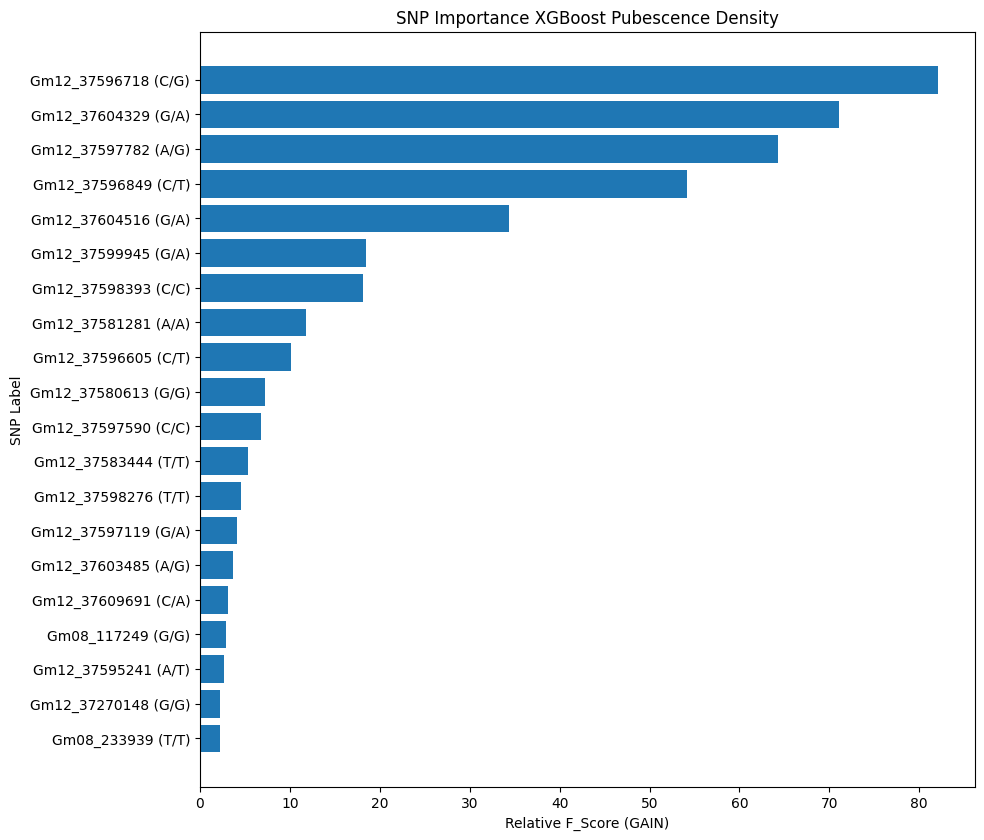

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
plt.barh(indexes, values)
plt.title('SNP Importance XGBoost Pubescence Density')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

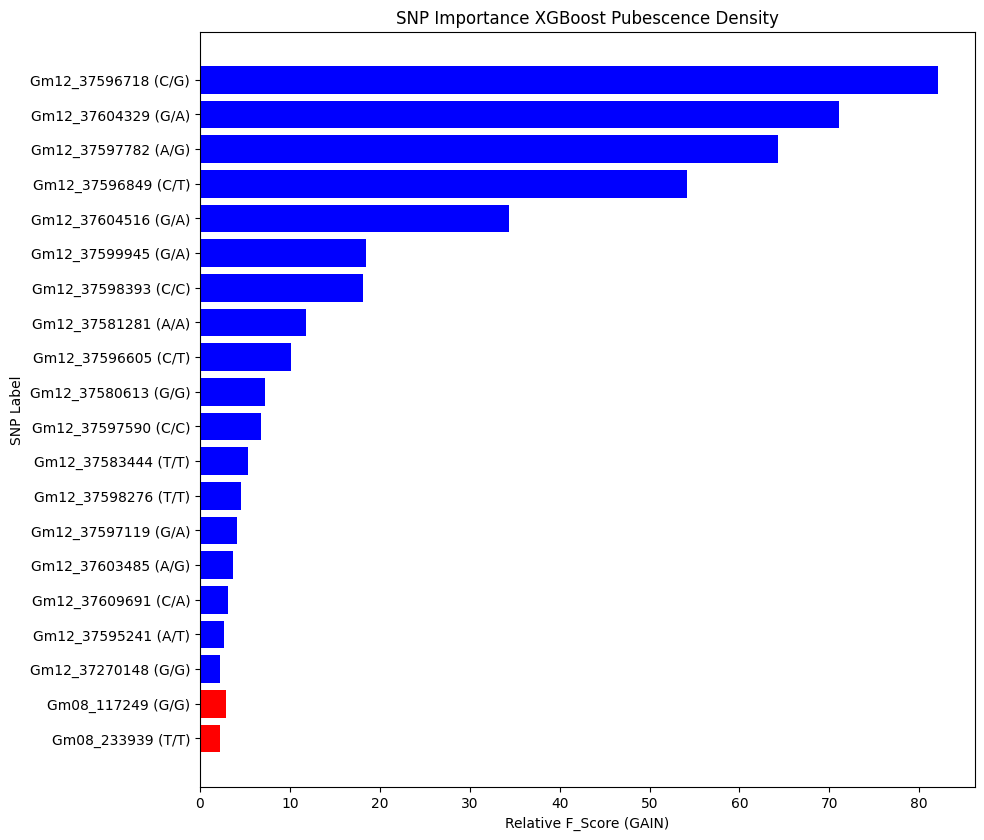

In [28]:
#generate figure object
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
#load in the 20 lardest values and their SNP label
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
#reverse to make the largest be at the front
indexes = indexes[::-1]
values = values[::-1]
#for each different chromosome you want to colour add a index(*_i) and value (*_v) array
#black would be colour for singular/notinteresting chromosomes
r_i = []
r_v = []
b_i = []
b_v = []
g_i = []
g_v = []
y_i = []
y_v = []
bl_i = []
bl_v = []
p_i = []
p_v = []
br_i = []
br_v = []
pu_i = []
pu_v = []
#for each value in the top n (default 20) check which chromosome it belongs to and add it to the colour array
i = 0
while i < len(indexes):
    if('Gm08' in indexes[i]):
        r_i.append(indexes[i])
        r_v.append(values[i])
    elif('Gm12' in indexes[i]):
        b_i.append(indexes[i])
        b_v.append(values[i])
    elif('Gm01' in indexes[i]):
        g_i.append(indexes[i])
        g_v.append(values[i])
    #elif('Gm11' in indexes[i]):
    #    y_i.append(indexes[i])
    #    y_v.append(values[i])
    #elif('Gm08' in indexes[i]):
    #    p_i.append(indexes[i])
    #    p_v.append(values[i])
   # elif('Gm04' in indexes[i]):
   #     br_i.append(indexes[i])
   #     br_v.append(values[i])
   # elif('Gm13' in indexes[i]):
   #     pu_i.append(indexes[i])
   #     pu_v.append(values[i])
    else:
        bl_i.append(indexes[i])
        bl_v.append(values[i])
    i = i + 1
#plot each of the arrays with appropriate colour and label graph
plt.barh(bl_i, bl_v, color="black")
plt.barh(br_i, br_v, color="brown")
plt.barh(pu_i, pu_v, color="purple")
plt.barh(y_i, y_v, color="yellow")
plt.barh(p_i, p_v, color="orange")
plt.barh(g_i, g_v, color="green")
plt.barh(r_i, r_v, color="red")
plt.barh(b_i, b_v, color="blue")
plt.title('SNP Importance XGBoost Pubescence Density')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

# Random Forest ML Model

In [7]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('PuD_Merged_filtered.csv_train_testQTL_SNPS.csv', 'PuD_Merged_filtered.csv_holdoutQTL_SNPS.csv')

(617,)
(617, 1)
10000
(155,)
(155, 1)
10000
(617, 1)
(617, 9258)
found 2
found 2
(615, 1)
(615, 9258)
(155, 1)
(155, 9258)
found 2
(154, 1)
(154, 9258)
(615, 9258)
(154, 9258)
(615, 1)
(154, 1)


In [8]:
ohe = pickle.load(open("PuD_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(615, 27061)
(154, 9258)
(154, 27061)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is85.48387096774194


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is93.54838709677419


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is93.54838709677419


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is96.7741935483871


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is82.25806451612904


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is80.32786885245902


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is83.60655737704919


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is85.24590163934425


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is90.1639344262295


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


variables for auroc curve done. Processing fold accuracy + checking best model
The accuracy of this model is91.80327868852459


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


88.96103896103897


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


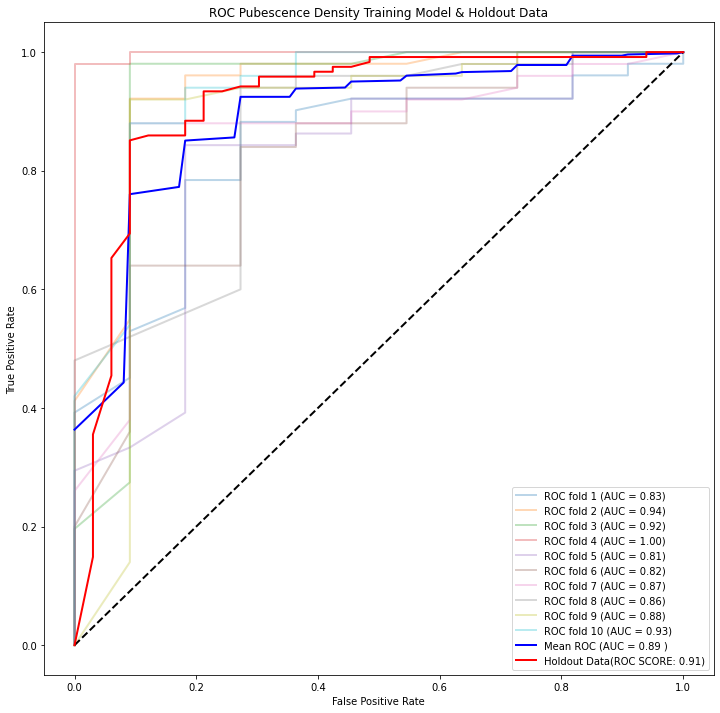

Training Testing Accuracy: 88.28% (5.31%)
Holdout Accuracy: 88.96%


In [9]:
seed = randint(0,5000)
rf_model = RandomForestClassifier(n_estimators=100, random_state=seed, max_features = 'sqrt',n_jobs=-1, verbose = 1)
best_rf_model = eval_k_fold(rf_model, tt_vcf, tt_pheno, 10, ho_vcf, ho_pheno)

In [10]:
import pickle
pickle.dump(best_rf_model, open("PuD_kfold_10_RF_QTL.dat", "wb"))

<AxesSubplot:>

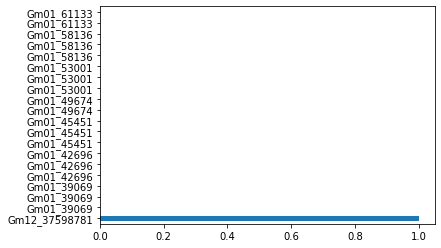

In [94]:
feat_importances = pd.Series(best_model.feature_importances_, index=n_headers)
feat_importances.nlargest(20).plot(kind='barh')

AttributeError: 'XGBClassifier' object has no attribute 'attributes_'

# CNN Model (based upon DL Primer)
### one hot encode and train test split like you usually do but follow the primer for the actual model part
### for BC and MC use primer, for regression use Philipps notebooks....

In [5]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('PuD_Merged_filtered.csv_train_testQTL_SNPS.csv', 'PuD_Merged_filtered.csv_holdoutQTL_SNPS.csv')

(617,)
(617, 1)
10000
(155,)
(155, 1)
10000
(617, 1)
(617, 9258)
found 2
found 2
(615, 1)
(615, 9258)
(155, 1)
(155, 9258)
found 2
(154, 1)
(154, 9258)
(615, 9258)
(154, 9258)
(615, 1)
(154, 1)


In [6]:
ohe = pickle.load(open("PuD_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(615, 27061)
(154, 9258)
(154, 27061)


In [7]:
def build_CNN_model(x_len):    
    #del model
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=14, 
                     input_shape=(x_len, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=10, kernel_size=10, 
                     input_shape=(12, 1)))
    model.add(Activation('linear'))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=8, kernel_size=8, 
                     input_shape=(10, 1)))
    model.add(Activation('linear'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(48, activation='linear'))
    model.add(Dense(32, activation='linear'))
    model.add(Dense(16, activation='linear'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"


    model.compile(loss='binary_crossentropy', optimizer=opt, 
                  metrics=['binary_accuracy'])

    print(model.summary())
    return model

In [8]:
def eval_cnn(x,y,k):
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    best_model = []
    results = []
    highest = 0
    i = 1
    for train,test in cv.split(x,y):
        x = x.reshape(x.shape[0], x.shape[1], 1)
        model = build_CNN_model(x[train].shape[1])
        bs = ((x[train].shape[0])/40)
        bs = round(bs)
        history = model.fit(x[train], y[train], validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        _, accuracy = model.evaluate(x[test], y[test], batch_size=bs, verbose=0)
        accuracy = accuracy *100
        print("accuracy for model " + str(i) + " is " + str(accuracy))
        if(accuracy > highest):
            highest = accuracy
            best_model = model
        results.append(accuracy)
        del model
        i = i + 1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results))) 
    return best_model

In [9]:
best_CNN = eval_cnn(tt_vcf, tt_pheno, 10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 27048, 12)         180       
_________________________________________________________________
activation (Activation)      (None, 27048, 12)         0         
_________________________________________________________________
dropout (Dropout)            (None, 27048, 12)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27039, 10)         1210      
_________________________________________________________________
activation_1 (Activation)    (None, 27039, 10)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 27039, 10)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27032, 8)          6

553/553 [==============================] - 0s 689us/sample - loss: 0.0346 - binary_accuracy: 0.9910 - val_loss: 0.7931 - val_binary_accuracy: 0.7903
Epoch 37/100
553/553 [==============================] - 0s 706us/sample - loss: 0.0281 - binary_accuracy: 0.9928 - val_loss: 3.7034 - val_binary_accuracy: 0.3065
Epoch 38/100
553/553 [==============================] - 0s 691us/sample - loss: 0.0369 - binary_accuracy: 0.9873 - val_loss: 1.0629 - val_binary_accuracy: 0.7581
Epoch 39/100
553/553 [==============================] - 0s 689us/sample - loss: 0.0399 - binary_accuracy: 0.9892 - val_loss: 0.8697 - val_binary_accuracy: 0.7903
Epoch 40/100
553/553 [==============================] - 0s 676us/sample - loss: 0.0203 - binary_accuracy: 0.9964 - val_loss: 0.7553 - val_binary_accuracy: 0.8065
Epoch 41/100
553/553 [==============================] - 0s 686us/sample - loss: 0.0196 - binary_accuracy: 0.9946 - val_loss: 0.8957 - val_binary_accuracy: 0.7742
Epoch 42/100
553/553 [===================

553/553 [==============================] - 0s 687us/sample - loss: 0.0034 - binary_accuracy: 1.0000 - val_loss: 0.9672 - val_binary_accuracy: 0.7742
Epoch 87/100
553/553 [==============================] - 0s 712us/sample - loss: 0.0146 - binary_accuracy: 0.9946 - val_loss: 0.8676 - val_binary_accuracy: 0.7903
Epoch 88/100
553/553 [==============================] - 0s 712us/sample - loss: 0.0122 - binary_accuracy: 0.9964 - val_loss: 1.0156 - val_binary_accuracy: 0.7903
Epoch 89/100
553/553 [==============================] - 0s 702us/sample - loss: 0.0098 - binary_accuracy: 0.9964 - val_loss: 1.7010 - val_binary_accuracy: 0.7581
Epoch 90/100
553/553 [==============================] - 0s 684us/sample - loss: 0.0056 - binary_accuracy: 1.0000 - val_loss: 1.0531 - val_binary_accuracy: 0.7903
Epoch 91/100
553/553 [==============================] - 0s 710us/sample - loss: 0.0063 - binary_accuracy: 1.0000 - val_loss: 0.9514 - val_binary_accuracy: 0.8065
Epoch 92/100
553/553 [===================

Epoch 21/100
553/553 [==============================] - 0s 701us/sample - loss: 0.0766 - binary_accuracy: 0.9765 - val_loss: 0.2793 - val_binary_accuracy: 0.9194
Epoch 22/100
553/553 [==============================] - 0s 682us/sample - loss: 0.0770 - binary_accuracy: 0.9729 - val_loss: 0.6515 - val_binary_accuracy: 0.8226
Epoch 23/100
553/553 [==============================] - 0s 680us/sample - loss: 0.0624 - binary_accuracy: 0.9837 - val_loss: 0.2657 - val_binary_accuracy: 0.9355
Epoch 24/100
553/553 [==============================] - 0s 692us/sample - loss: 0.0618 - binary_accuracy: 0.9855 - val_loss: 0.4693 - val_binary_accuracy: 0.8871
Epoch 25/100
553/553 [==============================] - 0s 696us/sample - loss: 0.0777 - binary_accuracy: 0.9711 - val_loss: 0.2829 - val_binary_accuracy: 0.9355
Epoch 26/100
553/553 [==============================] - 0s 682us/sample - loss: 0.0616 - binary_accuracy: 0.9855 - val_loss: 0.3777 - val_binary_accuracy: 0.8871
Epoch 27/100
553/553 [======

553/553 [==============================] - 0s 682us/sample - loss: 0.0182 - binary_accuracy: 0.9964 - val_loss: 0.7687 - val_binary_accuracy: 0.8065
Epoch 72/100
553/553 [==============================] - 0s 689us/sample - loss: 0.0206 - binary_accuracy: 0.9964 - val_loss: 0.3354 - val_binary_accuracy: 0.8871
Epoch 73/100
553/553 [==============================] - 0s 693us/sample - loss: 0.0129 - binary_accuracy: 1.0000 - val_loss: 0.2860 - val_binary_accuracy: 0.9355
Epoch 74/100
553/553 [==============================] - 0s 679us/sample - loss: 0.0234 - binary_accuracy: 0.9928 - val_loss: 0.3284 - val_binary_accuracy: 0.9032
Epoch 75/100
553/553 [==============================] - 0s 714us/sample - loss: 0.0136 - binary_accuracy: 0.9964 - val_loss: 0.3426 - val_binary_accuracy: 0.9032
Epoch 76/100
553/553 [==============================] - 0s 709us/sample - loss: 0.0286 - binary_accuracy: 0.9892 - val_loss: 0.3268 - val_binary_accuracy: 0.9032
Epoch 77/100
553/553 [===================

Epoch 6/100
553/553 [==============================] - 0s 679us/sample - loss: 0.2613 - binary_accuracy: 0.9114 - val_loss: 0.2928 - val_binary_accuracy: 0.8226
Epoch 7/100
553/553 [==============================] - 0s 704us/sample - loss: 0.2215 - binary_accuracy: 0.9277 - val_loss: 0.2709 - val_binary_accuracy: 0.8710
Epoch 8/100
553/553 [==============================] - 0s 703us/sample - loss: 0.2058 - binary_accuracy: 0.9222 - val_loss: 0.2120 - val_binary_accuracy: 0.9194
Epoch 9/100
553/553 [==============================] - 0s 683us/sample - loss: 0.1943 - binary_accuracy: 0.9331 - val_loss: 0.2262 - val_binary_accuracy: 0.9355
Epoch 10/100
553/553 [==============================] - 0s 708us/sample - loss: 0.1849 - binary_accuracy: 0.9458 - val_loss: 0.2073 - val_binary_accuracy: 0.9032
Epoch 11/100
553/553 [==============================] - 0s 690us/sample - loss: 0.1754 - binary_accuracy: 0.9331 - val_loss: 0.1555 - val_binary_accuracy: 0.9516
Epoch 12/100
553/553 [==========

553/553 [==============================] - 0s 677us/sample - loss: 0.0218 - binary_accuracy: 0.9964 - val_loss: 0.4303 - val_binary_accuracy: 0.9355
Epoch 57/100
553/553 [==============================] - 0s 685us/sample - loss: 0.0181 - binary_accuracy: 0.9946 - val_loss: 0.4241 - val_binary_accuracy: 0.9355
Epoch 58/100
553/553 [==============================] - 0s 673us/sample - loss: 0.0202 - binary_accuracy: 0.9964 - val_loss: 0.3997 - val_binary_accuracy: 0.9355
Epoch 59/100
553/553 [==============================] - 0s 690us/sample - loss: 0.0140 - binary_accuracy: 0.9946 - val_loss: 0.3503 - val_binary_accuracy: 0.9355
Epoch 60/100
553/553 [==============================] - 0s 684us/sample - loss: 0.0202 - binary_accuracy: 0.9964 - val_loss: 0.3978 - val_binary_accuracy: 0.9355
Epoch 61/100
553/553 [==============================] - 0s 694us/sample - loss: 0.0283 - binary_accuracy: 0.9892 - val_loss: 0.3617 - val_binary_accuracy: 0.9355
Epoch 62/100
553/553 [===================

Train on 553 samples, validate on 62 samples
Epoch 1/100
553/553 [==============================] - 1s 2ms/sample - loss: 0.6311 - binary_accuracy: 0.7396 - val_loss: 0.4482 - val_binary_accuracy: 0.9516
Epoch 2/100
553/553 [==============================] - 0s 667us/sample - loss: 0.4633 - binary_accuracy: 0.8210 - val_loss: 0.3853 - val_binary_accuracy: 0.8710
Epoch 3/100
553/553 [==============================] - 0s 665us/sample - loss: 0.3854 - binary_accuracy: 0.8788 - val_loss: 0.3446 - val_binary_accuracy: 0.8226
Epoch 4/100
553/553 [==============================] - 0s 669us/sample - loss: 0.3314 - binary_accuracy: 0.8879 - val_loss: 0.2691 - val_binary_accuracy: 0.9677
Epoch 5/100
553/553 [==============================] - 0s 680us/sample - loss: 0.3307 - binary_accuracy: 0.8770 - val_loss: 0.2445 - val_binary_accuracy: 0.9677
Epoch 6/100
553/553 [==============================] - 0s 672us/sample - loss: 0.2797 - binary_accuracy: 0.9005 - val_loss: 0.1782 - val_binary_accuracy

553/553 [==============================] - 0s 687us/sample - loss: 0.0479 - binary_accuracy: 0.9873 - val_loss: 0.2946 - val_binary_accuracy: 0.9355
Epoch 52/100
553/553 [==============================] - 0s 668us/sample - loss: 0.0265 - binary_accuracy: 0.9928 - val_loss: 1.8211 - val_binary_accuracy: 0.5000
Epoch 53/100
553/553 [==============================] - 0s 702us/sample - loss: 0.0226 - binary_accuracy: 0.9964 - val_loss: 0.3397 - val_binary_accuracy: 0.8871
Epoch 54/100
553/553 [==============================] - 0s 675us/sample - loss: 0.0189 - binary_accuracy: 0.9964 - val_loss: 0.3048 - val_binary_accuracy: 0.8871
Epoch 55/100
553/553 [==============================] - 0s 682us/sample - loss: 0.0156 - binary_accuracy: 1.0000 - val_loss: 0.2565 - val_binary_accuracy: 0.9355
Epoch 56/100
553/553 [==============================] - 0s 678us/sample - loss: 0.0168 - binary_accuracy: 0.9964 - val_loss: 0.2557 - val_binary_accuracy: 0.9194
Epoch 57/100
553/553 [===================

Train on 553 samples, validate on 62 samples
Epoch 1/100
553/553 [==============================] - 1s 2ms/sample - loss: 0.5879 - binary_accuracy: 0.7776 - val_loss: 0.5601 - val_binary_accuracy: 0.7903
Epoch 2/100
553/553 [==============================] - 0s 697us/sample - loss: 0.4050 - binary_accuracy: 0.8662 - val_loss: 0.4436 - val_binary_accuracy: 0.8387
Epoch 3/100
553/553 [==============================] - 0s 700us/sample - loss: 0.3576 - binary_accuracy: 0.8915 - val_loss: 0.4462 - val_binary_accuracy: 0.8226
Epoch 4/100
553/553 [==============================] - 0s 666us/sample - loss: 0.2944 - binary_accuracy: 0.9078 - val_loss: 0.4100 - val_binary_accuracy: 0.8226
Epoch 5/100
553/553 [==============================] - 0s 671us/sample - loss: 0.2753 - binary_accuracy: 0.9204 - val_loss: 0.3811 - val_binary_accuracy: 0.8226
Epoch 6/100
553/553 [==============================] - 0s 707us/sample - loss: 0.2644 - binary_accuracy: 0.9060 - val_loss: 0.3857 - val_binary_accuracy

553/553 [==============================] - 0s 680us/sample - loss: 0.0275 - binary_accuracy: 0.9873 - val_loss: 1.1557 - val_binary_accuracy: 0.8065
Epoch 52/100
553/553 [==============================] - 0s 690us/sample - loss: 0.0538 - binary_accuracy: 0.9855 - val_loss: 1.7283 - val_binary_accuracy: 0.6129
Epoch 53/100
553/553 [==============================] - 0s 672us/sample - loss: 0.0221 - binary_accuracy: 0.9964 - val_loss: 1.0469 - val_binary_accuracy: 0.7903
Epoch 54/100
553/553 [==============================] - 0s 694us/sample - loss: 0.0278 - binary_accuracy: 0.9873 - val_loss: 1.0795 - val_binary_accuracy: 0.8226
Epoch 55/100
553/553 [==============================] - 0s 682us/sample - loss: 0.0276 - binary_accuracy: 0.9928 - val_loss: 0.8940 - val_binary_accuracy: 0.7903
Epoch 56/100
553/553 [==============================] - 0s 679us/sample - loss: 0.0164 - binary_accuracy: 0.9982 - val_loss: 0.9230 - val_binary_accuracy: 0.8065
Epoch 57/100
553/553 [===================

Train on 554 samples, validate on 61 samples
Epoch 1/100
554/554 [==============================] - 1s 2ms/sample - loss: 0.5591 - binary_accuracy: 0.7726 - val_loss: 0.5208 - val_binary_accuracy: 0.7705
Epoch 2/100
554/554 [==============================] - 0s 841us/sample - loss: 0.4144 - binary_accuracy: 0.8574 - val_loss: 0.4577 - val_binary_accuracy: 0.8689
Epoch 3/100
554/554 [==============================] - 0s 698us/sample - loss: 0.3445 - binary_accuracy: 0.8845 - val_loss: 0.4066 - val_binary_accuracy: 0.8361
Epoch 4/100
554/554 [==============================] - 0s 697us/sample - loss: 0.3048 - binary_accuracy: 0.8971 - val_loss: 0.3732 - val_binary_accuracy: 0.8361
Epoch 5/100
554/554 [==============================] - 0s 673us/sample - loss: 0.2816 - binary_accuracy: 0.8989 - val_loss: 0.3602 - val_binary_accuracy: 0.8197
Epoch 6/100
554/554 [==============================] - 0s 693us/sample - loss: 0.2660 - binary_accuracy: 0.9079 - val_loss: 0.3603 - val_binary_accuracy

554/554 [==============================] - 0s 681us/sample - loss: 0.0234 - binary_accuracy: 0.9964 - val_loss: 0.6064 - val_binary_accuracy: 0.8525
Epoch 52/100
554/554 [==============================] - 0s 680us/sample - loss: 0.0146 - binary_accuracy: 0.9982 - val_loss: 0.6681 - val_binary_accuracy: 0.8361
Epoch 53/100
554/554 [==============================] - 0s 683us/sample - loss: 0.0165 - binary_accuracy: 0.9964 - val_loss: 0.6468 - val_binary_accuracy: 0.8197
Epoch 54/100
554/554 [==============================] - 0s 674us/sample - loss: 0.0250 - binary_accuracy: 0.9928 - val_loss: 0.6912 - val_binary_accuracy: 0.8852
Epoch 55/100
554/554 [==============================] - 0s 665us/sample - loss: 0.0274 - binary_accuracy: 0.9946 - val_loss: 0.6738 - val_binary_accuracy: 0.8525
Epoch 56/100
554/554 [==============================] - 0s 673us/sample - loss: 0.0351 - binary_accuracy: 0.9874 - val_loss: 0.7215 - val_binary_accuracy: 0.8689
Epoch 57/100
554/554 [===================

Train on 554 samples, validate on 61 samples
Epoch 1/100
554/554 [==============================] - 1s 2ms/sample - loss: 0.5707 - binary_accuracy: 0.7527 - val_loss: 0.5615 - val_binary_accuracy: 0.8033
Epoch 2/100
554/554 [==============================] - 0s 684us/sample - loss: 0.4387 - binary_accuracy: 0.8394 - val_loss: 0.4877 - val_binary_accuracy: 0.8033
Epoch 3/100
554/554 [==============================] - 0s 672us/sample - loss: 0.3578 - binary_accuracy: 0.8845 - val_loss: 0.4199 - val_binary_accuracy: 0.8197
Epoch 4/100
554/554 [==============================] - 0s 669us/sample - loss: 0.2962 - binary_accuracy: 0.9206 - val_loss: 0.3850 - val_binary_accuracy: 0.8197
Epoch 5/100
554/554 [==============================] - 0s 667us/sample - loss: 0.2766 - binary_accuracy: 0.9134 - val_loss: 0.3973 - val_binary_accuracy: 0.8197
Epoch 6/100
554/554 [==============================] - 0s 673us/sample - loss: 0.2300 - binary_accuracy: 0.9242 - val_loss: 0.3858 - val_binary_accuracy

554/554 [==============================] - 0s 687us/sample - loss: 0.0111 - binary_accuracy: 0.9964 - val_loss: 0.7137 - val_binary_accuracy: 0.8361
Epoch 52/100
554/554 [==============================] - 0s 691us/sample - loss: 0.0166 - binary_accuracy: 0.9946 - val_loss: 0.7440 - val_binary_accuracy: 0.8197
Epoch 53/100
554/554 [==============================] - 0s 665us/sample - loss: 0.0224 - binary_accuracy: 0.9982 - val_loss: 0.8155 - val_binary_accuracy: 0.8033
Epoch 54/100
554/554 [==============================] - 0s 678us/sample - loss: 0.0093 - binary_accuracy: 1.0000 - val_loss: 1.0025 - val_binary_accuracy: 0.8033
Epoch 55/100
554/554 [==============================] - 0s 674us/sample - loss: 0.0109 - binary_accuracy: 0.9982 - val_loss: 0.9128 - val_binary_accuracy: 0.8361
Epoch 56/100
554/554 [==============================] - 0s 665us/sample - loss: 0.0061 - binary_accuracy: 1.0000 - val_loss: 0.8446 - val_binary_accuracy: 0.8361
Epoch 57/100
554/554 [===================

Train on 554 samples, validate on 61 samples
Epoch 1/100
554/554 [==============================] - 1s 2ms/sample - loss: 0.6314 - binary_accuracy: 0.7076 - val_loss: 0.5235 - val_binary_accuracy: 0.9016
Epoch 2/100
554/554 [==============================] - 0s 685us/sample - loss: 0.4338 - binary_accuracy: 0.8466 - val_loss: 0.4724 - val_binary_accuracy: 0.8525
Epoch 3/100
554/554 [==============================] - 0s 675us/sample - loss: 0.3526 - binary_accuracy: 0.8953 - val_loss: 0.4427 - val_binary_accuracy: 0.8361
Epoch 4/100
554/554 [==============================] - 0s 670us/sample - loss: 0.3125 - binary_accuracy: 0.8989 - val_loss: 0.4020 - val_binary_accuracy: 0.8197
Epoch 5/100
554/554 [==============================] - 0s 675us/sample - loss: 0.2992 - binary_accuracy: 0.9079 - val_loss: 0.3985 - val_binary_accuracy: 0.8361
Epoch 6/100
554/554 [==============================] - 0s 689us/sample - loss: 0.2608 - binary_accuracy: 0.9116 - val_loss: 0.4194 - val_binary_accuracy

554/554 [==============================] - 0s 665us/sample - loss: 0.0225 - binary_accuracy: 0.9928 - val_loss: 0.5399 - val_binary_accuracy: 0.8689
Epoch 52/100
554/554 [==============================] - 0s 675us/sample - loss: 0.0216 - binary_accuracy: 0.9982 - val_loss: 0.5964 - val_binary_accuracy: 0.8689
Epoch 53/100
554/554 [==============================] - 0s 664us/sample - loss: 0.0166 - binary_accuracy: 0.9982 - val_loss: 0.6346 - val_binary_accuracy: 0.8525
Epoch 54/100
554/554 [==============================] - 0s 674us/sample - loss: 0.0205 - binary_accuracy: 0.9964 - val_loss: 0.4110 - val_binary_accuracy: 0.8525
Epoch 55/100
554/554 [==============================] - 0s 677us/sample - loss: 0.0394 - binary_accuracy: 0.9892 - val_loss: 0.9052 - val_binary_accuracy: 0.8525
Epoch 56/100
554/554 [==============================] - 0s 682us/sample - loss: 0.0152 - binary_accuracy: 0.9982 - val_loss: 0.6979 - val_binary_accuracy: 0.7213
Epoch 57/100
554/554 [===================

Train on 554 samples, validate on 61 samples
Epoch 1/100
554/554 [==============================] - 1s 2ms/sample - loss: 0.5695 - binary_accuracy: 0.7383 - val_loss: 0.5040 - val_binary_accuracy: 0.9016
Epoch 2/100
554/554 [==============================] - 0s 681us/sample - loss: 0.4297 - binary_accuracy: 0.8628 - val_loss: 0.4147 - val_binary_accuracy: 0.8197
Epoch 3/100
554/554 [==============================] - 0s 690us/sample - loss: 0.3617 - binary_accuracy: 0.8827 - val_loss: 0.3721 - val_binary_accuracy: 0.8197
Epoch 4/100
554/554 [==============================] - 0s 683us/sample - loss: 0.3161 - binary_accuracy: 0.8953 - val_loss: 0.3640 - val_binary_accuracy: 0.8197
Epoch 5/100
554/554 [==============================] - 0s 688us/sample - loss: 0.2874 - binary_accuracy: 0.9061 - val_loss: 0.3162 - val_binary_accuracy: 0.8197
Epoch 6/100
554/554 [==============================] - 0s 666us/sample - loss: 0.2560 - binary_accuracy: 0.9134 - val_loss: 0.2799 - val_binary_accuracy

554/554 [==============================] - 0s 677us/sample - loss: 0.0087 - binary_accuracy: 1.0000 - val_loss: 0.3703 - val_binary_accuracy: 0.8852
Epoch 52/100
554/554 [==============================] - 0s 691us/sample - loss: 0.0155 - binary_accuracy: 0.9982 - val_loss: 0.4215 - val_binary_accuracy: 0.8852
Epoch 53/100
554/554 [==============================] - 0s 673us/sample - loss: 0.0111 - binary_accuracy: 0.9964 - val_loss: 0.4178 - val_binary_accuracy: 0.8852
Epoch 54/100
554/554 [==============================] - 0s 687us/sample - loss: 0.0135 - binary_accuracy: 0.9982 - val_loss: 0.6269 - val_binary_accuracy: 0.8361
Epoch 55/100
554/554 [==============================] - 0s 677us/sample - loss: 0.0309 - binary_accuracy: 0.9838 - val_loss: 0.3219 - val_binary_accuracy: 0.8852
Epoch 56/100
554/554 [==============================] - 0s 676us/sample - loss: 0.0543 - binary_accuracy: 0.9838 - val_loss: 0.5516 - val_binary_accuracy: 0.9016
Epoch 57/100
554/554 [===================

Train on 554 samples, validate on 61 samples
Epoch 1/100
554/554 [==============================] - 1s 2ms/sample - loss: 0.5770 - binary_accuracy: 0.7671 - val_loss: 0.5252 - val_binary_accuracy: 0.8689
Epoch 2/100
554/554 [==============================] - 0s 675us/sample - loss: 0.4339 - binary_accuracy: 0.8430 - val_loss: 0.4048 - val_binary_accuracy: 0.8361
Epoch 3/100
554/554 [==============================] - 0s 692us/sample - loss: 0.3589 - binary_accuracy: 0.8809 - val_loss: 0.3705 - val_binary_accuracy: 0.8361
Epoch 4/100
554/554 [==============================] - 0s 688us/sample - loss: 0.3176 - binary_accuracy: 0.8953 - val_loss: 0.3252 - val_binary_accuracy: 0.8361
Epoch 5/100
554/554 [==============================] - 0s 688us/sample - loss: 0.2965 - binary_accuracy: 0.8971 - val_loss: 0.3036 - val_binary_accuracy: 0.8361
Epoch 6/100
554/554 [==============================] - 0s 691us/sample - loss: 0.2631 - binary_accuracy: 0.9079 - val_loss: 0.3135 - val_binary_accuracy

554/554 [==============================] - 0s 666us/sample - loss: 0.0278 - binary_accuracy: 0.9928 - val_loss: 0.2518 - val_binary_accuracy: 0.9344
Epoch 52/100
554/554 [==============================] - 0s 670us/sample - loss: 0.0340 - binary_accuracy: 0.9874 - val_loss: 0.3332 - val_binary_accuracy: 0.9180
Epoch 53/100
554/554 [==============================] - 0s 677us/sample - loss: 0.0385 - binary_accuracy: 0.9819 - val_loss: 0.6627 - val_binary_accuracy: 0.8689
Epoch 54/100
554/554 [==============================] - 0s 681us/sample - loss: 0.0501 - binary_accuracy: 0.9819 - val_loss: 0.8230 - val_binary_accuracy: 0.7213
Epoch 55/100
554/554 [==============================] - 0s 693us/sample - loss: 0.0288 - binary_accuracy: 0.9928 - val_loss: 0.2985 - val_binary_accuracy: 0.9016
Epoch 56/100
554/554 [==============================] - 0s 677us/sample - loss: 0.0181 - binary_accuracy: 0.9946 - val_loss: 0.6415 - val_binary_accuracy: 0.8852
Epoch 57/100
554/554 [===================

In [10]:
bs = ((ho_vcf.shape[0])/40)
bs = round(bs)
ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1],1)
_, accuracy = best_CNN.evaluate(ho_vcf, ho_pheno, batch_size=bs, verbose=0)
print("Holdout accuracy is " + str(accuracy*100))

Holdout accuracy is 87.01298832893372


In [11]:
import pickle
pickle.dump(best_CNN, open("PuD_kfold_10_CNN_QTL.dat", "wb"))

TypeError: can't pickle _thread.RLock objects

# DNN Model

In [12]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('PuD_Merged_filtered.csv_train_testQTL_SNPS.csv', 'PuD_Merged_filtered.csv_holdoutQTL_SNPS.csv')

(617,)
(617, 1)
10000
(155,)
(155, 1)
10000
(617, 1)
(617, 9258)
found 2
found 2
(615, 1)
(615, 9258)
(155, 1)
(155, 9258)
found 2
(154, 1)
(154, 9258)
(615, 9258)
(154, 9258)
(615, 1)
(154, 1)


In [13]:
ohe = pickle.load(open("PuD_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(615, 27061)
(154, 9258)
(154, 27061)


In [ ]:
tt_vcf, tt_pheno, ho_vcf, ho_pheno, all_vcf = prep_data('FlC_Merged_filtered.csv_train_test.csv_5pcnt.csv', 'FlC_Merged_filtered.csv_holdout.csv_5pcnt.csv')
#even though its binary, its still good to one hot encode it
mlb = MultiLabelBinarizer()
tt_pheno = mlb.fit_transform(tt_pheno)
ho_pheno = mlb.fit_transform(ho_pheno)
print(tt_pheno.shape)
print(ho_pheno.shape)
del all_vcf

In [14]:
#My own DNN model based upon paper
#del model #incase its stored a previous model
#del history #for redoing shit

#do batch size as 64
#reduce the inputs by half when you read it in
#add XGboost and RF to the one notebook
def build_DNN_model(x_len):
    model = Sequential()

    #add first input layer, with no normalization
    model.add(Dense(256, input_dim = x_len))
    model.add(Activation('relu'))
    model.add(Dropout(0.03))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.02))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.01))
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(16))
    model.add(Activation('relu'))
    #add output layer
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
    print(model.summary())
    return model



In [15]:
def eval_dnn(x,y,k): 
    cv = StratifiedKFold(n_splits=k,shuffle=False)
    best_model = []
    results = []
    highest = 0
    i = 1
    for train,test in cv.split(x,y):
        model = build_DNN_model(x[train].shape[1])
        bs = ((x[train].shape[0])/40)
        bs = round(bs)
        history = model.fit(x[train], y[train], validation_data=(x[test], y[test]), epochs = 100, batch_size=bs)
        _, accuracy = model.evaluate(x[test], y[test], batch_size=bs, verbose=0)
        accuracy = accuracy * 100
        print("accuracy for model " + str(i) + " is " + str(accuracy))
        if(accuracy > highest):
            highest = accuracy
            best_model = model
        results.append(accuracy)
        i = i + 1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results))) 
    return best_model

In [16]:
best_DNN = eval_dnn(tt_vcf, tt_pheno, 10)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               6927872   
_________________________________________________________________
activation_30 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_31 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)              

Epoch 37/100
553/553 [==============================] - 0s 372us/sample - loss: 0.1081 - binary_accuracy: 0.9602 - val_loss: 0.8189 - val_binary_accuracy: 0.7742
Epoch 38/100
553/553 [==============================] - 0s 367us/sample - loss: 0.0974 - binary_accuracy: 0.9711 - val_loss: 0.6267 - val_binary_accuracy: 0.8548
Epoch 39/100
553/553 [==============================] - 0s 374us/sample - loss: 0.0877 - binary_accuracy: 0.9675 - val_loss: 0.7173 - val_binary_accuracy: 0.8548
Epoch 40/100
553/553 [==============================] - 0s 366us/sample - loss: 0.0887 - binary_accuracy: 0.9711 - val_loss: 0.5715 - val_binary_accuracy: 0.8226
Epoch 41/100
553/553 [==============================] - 0s 368us/sample - loss: 0.1030 - binary_accuracy: 0.9620 - val_loss: 0.7073 - val_binary_accuracy: 0.6774
Epoch 42/100
553/553 [==============================] - 0s 369us/sample - loss: 0.1367 - binary_accuracy: 0.9494 - val_loss: 0.7257 - val_binary_accuracy: 0.7419
Epoch 43/100
553/553 [======

553/553 [==============================] - 0s 369us/sample - loss: 0.0297 - binary_accuracy: 0.9928 - val_loss: 0.9445 - val_binary_accuracy: 0.8226
Epoch 88/100
553/553 [==============================] - 0s 367us/sample - loss: 0.0250 - binary_accuracy: 0.9910 - val_loss: 1.1638 - val_binary_accuracy: 0.7903
Epoch 89/100
553/553 [==============================] - 0s 367us/sample - loss: 0.0423 - binary_accuracy: 0.9837 - val_loss: 0.8656 - val_binary_accuracy: 0.8548
Epoch 90/100
553/553 [==============================] - 0s 369us/sample - loss: 0.0261 - binary_accuracy: 0.9928 - val_loss: 0.8872 - val_binary_accuracy: 0.8387
Epoch 91/100
553/553 [==============================] - 0s 370us/sample - loss: 0.0155 - binary_accuracy: 0.9928 - val_loss: 1.0223 - val_binary_accuracy: 0.8226
Epoch 92/100
553/553 [==============================] - 0s 367us/sample - loss: 0.0194 - binary_accuracy: 0.9946 - val_loss: 1.2519 - val_binary_accuracy: 0.8065
Epoch 93/100
553/553 [===================

Epoch 23/100
553/553 [==============================] - 0s 368us/sample - loss: 0.1449 - binary_accuracy: 0.9476 - val_loss: 0.1929 - val_binary_accuracy: 0.9355
Epoch 24/100
553/553 [==============================] - 0s 366us/sample - loss: 0.1515 - binary_accuracy: 0.9512 - val_loss: 0.2281 - val_binary_accuracy: 0.9194
Epoch 25/100
553/553 [==============================] - 0s 369us/sample - loss: 0.1664 - binary_accuracy: 0.9367 - val_loss: 0.2149 - val_binary_accuracy: 0.9355
Epoch 26/100
553/553 [==============================] - 0s 368us/sample - loss: 0.1331 - binary_accuracy: 0.9530 - val_loss: 0.2279 - val_binary_accuracy: 0.9355
Epoch 27/100
553/553 [==============================] - 0s 368us/sample - loss: 0.1611 - binary_accuracy: 0.9439 - val_loss: 0.1877 - val_binary_accuracy: 0.9194
Epoch 28/100
553/553 [==============================] - 0s 370us/sample - loss: 0.1281 - binary_accuracy: 0.9494 - val_loss: 0.2122 - val_binary_accuracy: 0.9194
Epoch 29/100
553/553 [======

553/553 [==============================] - 0s 365us/sample - loss: 0.0190 - binary_accuracy: 0.9928 - val_loss: 0.2534 - val_binary_accuracy: 0.9516
Epoch 74/100
553/553 [==============================] - 0s 366us/sample - loss: 0.0426 - binary_accuracy: 0.9873 - val_loss: 0.3296 - val_binary_accuracy: 0.9194
Epoch 75/100
553/553 [==============================] - 0s 366us/sample - loss: 0.0340 - binary_accuracy: 0.9801 - val_loss: 0.2097 - val_binary_accuracy: 0.9355
Epoch 76/100
553/553 [==============================] - 0s 372us/sample - loss: 0.0535 - binary_accuracy: 0.9747 - val_loss: 0.5270 - val_binary_accuracy: 0.8548
Epoch 77/100
553/553 [==============================] - 0s 368us/sample - loss: 0.0453 - binary_accuracy: 0.9873 - val_loss: 0.3285 - val_binary_accuracy: 0.9194
Epoch 78/100
553/553 [==============================] - 0s 367us/sample - loss: 0.0613 - binary_accuracy: 0.9747 - val_loss: 0.3930 - val_binary_accuracy: 0.9516
Epoch 79/100
553/553 [===================

Epoch 9/100
553/553 [==============================] - 0s 369us/sample - loss: 0.2623 - binary_accuracy: 0.8987 - val_loss: 0.1458 - val_binary_accuracy: 0.9355
Epoch 10/100
553/553 [==============================] - 0s 368us/sample - loss: 0.2525 - binary_accuracy: 0.9114 - val_loss: 0.1894 - val_binary_accuracy: 0.9194
Epoch 11/100
553/553 [==============================] - 0s 369us/sample - loss: 0.2216 - binary_accuracy: 0.9114 - val_loss: 0.2388 - val_binary_accuracy: 0.9355
Epoch 12/100
553/553 [==============================] - 0s 368us/sample - loss: 0.2093 - binary_accuracy: 0.9150 - val_loss: 0.1897 - val_binary_accuracy: 0.9355
Epoch 13/100
553/553 [==============================] - 0s 367us/sample - loss: 0.2326 - binary_accuracy: 0.8987 - val_loss: 0.2807 - val_binary_accuracy: 0.9194
Epoch 14/100
553/553 [==============================] - 0s 368us/sample - loss: 0.2267 - binary_accuracy: 0.9078 - val_loss: 0.2913 - val_binary_accuracy: 0.9032
Epoch 15/100
553/553 [=======

553/553 [==============================] - 0s 368us/sample - loss: 0.0446 - binary_accuracy: 0.9819 - val_loss: 0.2731 - val_binary_accuracy: 0.9194
Epoch 60/100
553/553 [==============================] - 0s 369us/sample - loss: 0.0540 - binary_accuracy: 0.9783 - val_loss: 0.2609 - val_binary_accuracy: 0.9355
Epoch 61/100
553/553 [==============================] - 0s 373us/sample - loss: 0.0355 - binary_accuracy: 0.9873 - val_loss: 0.2859 - val_binary_accuracy: 0.9355
Epoch 62/100
553/553 [==============================] - 0s 373us/sample - loss: 0.0411 - binary_accuracy: 0.9855 - val_loss: 0.2935 - val_binary_accuracy: 0.9355
Epoch 63/100
553/553 [==============================] - 0s 370us/sample - loss: 0.0676 - binary_accuracy: 0.9729 - val_loss: 0.2686 - val_binary_accuracy: 0.9355
Epoch 64/100
553/553 [==============================] - 0s 368us/sample - loss: 0.0385 - binary_accuracy: 0.9855 - val_loss: 0.4209 - val_binary_accuracy: 0.9355
Epoch 65/100
553/553 [===================

Train on 553 samples, validate on 62 samples
Epoch 1/100
553/553 [==============================] - 1s 1ms/sample - loss: 0.4251 - binary_accuracy: 0.8083 - val_loss: 1.1130 - val_binary_accuracy: 0.8226
Epoch 2/100
553/553 [==============================] - 0s 366us/sample - loss: 0.3271 - binary_accuracy: 0.8517 - val_loss: 0.3718 - val_binary_accuracy: 0.8226
Epoch 3/100
553/553 [==============================] - 0s 367us/sample - loss: 0.2990 - binary_accuracy: 0.8608 - val_loss: 0.2207 - val_binary_accuracy: 0.8871
Epoch 4/100
553/553 [==============================] - 0s 366us/sample - loss: 0.2878 - binary_accuracy: 0.8752 - val_loss: 0.1463 - val_binary_accuracy: 0.9516
Epoch 5/100
553/553 [==============================] - 0s 366us/sample - loss: 0.2601 - binary_accuracy: 0.8825 - val_loss: 0.1775 - val_binary_accuracy: 0.9677
Epoch 6/100
553/553 [==============================] - 0s 367us/sample - loss: 0.2555 - binary_accuracy: 0.8788 - val_loss: 0.1461 - val_binary_accuracy

553/553 [==============================] - 0s 367us/sample - loss: 0.0775 - binary_accuracy: 0.9819 - val_loss: 0.7387 - val_binary_accuracy: 0.8226
Epoch 52/100
553/553 [==============================] - 0s 368us/sample - loss: 0.0544 - binary_accuracy: 0.9892 - val_loss: 0.0913 - val_binary_accuracy: 0.9677
Epoch 53/100
553/553 [==============================] - 0s 366us/sample - loss: 0.0782 - binary_accuracy: 0.9711 - val_loss: 0.3956 - val_binary_accuracy: 0.8710
Epoch 54/100
553/553 [==============================] - 0s 366us/sample - loss: 0.0606 - binary_accuracy: 0.9765 - val_loss: 0.2013 - val_binary_accuracy: 0.9194
Epoch 55/100
553/553 [==============================] - 0s 373us/sample - loss: 0.0616 - binary_accuracy: 0.9837 - val_loss: 1.0421 - val_binary_accuracy: 0.4677
Epoch 56/100
553/553 [==============================] - 0s 366us/sample - loss: 0.0561 - binary_accuracy: 0.9837 - val_loss: 0.3831 - val_binary_accuracy: 0.9032
Epoch 57/100
553/553 [===================

activation_53 (Activation)   (None, 32)                0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
dense_68 (Dense)             (None, 16)                528       
_________________________________________________________________
activation_54 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 17        
Total params: 6,971,777
Trainable params: 6,971,713
Non-trainable params: 64
_________________________________________________________________
None
Train on 553 samples, validate on 62 samples
Epoch 1/100
553/553 [==============================] - 1s 1ms/sample - loss: 0.4245 - binary_accuracy: 0.8065 - val_loss: 0.6915 - val_binary_accuracy: 0.8226
Epoch 2/100
553/553 [==============================] -

553/553 [==============================] - 0s 365us/sample - loss: 0.0553 - binary_accuracy: 0.9783 - val_loss: 0.8367 - val_binary_accuracy: 0.8548
Epoch 47/100
553/553 [==============================] - 0s 367us/sample - loss: 0.0477 - binary_accuracy: 0.9855 - val_loss: 0.8042 - val_binary_accuracy: 0.8226
Epoch 48/100
553/553 [==============================] - 0s 368us/sample - loss: 0.0352 - binary_accuracy: 0.9855 - val_loss: 0.8509 - val_binary_accuracy: 0.8065
Epoch 49/100
553/553 [==============================] - 0s 367us/sample - loss: 0.0491 - binary_accuracy: 0.9837 - val_loss: 0.7672 - val_binary_accuracy: 0.8226
Epoch 50/100
553/553 [==============================] - 0s 365us/sample - loss: 0.0578 - binary_accuracy: 0.9819 - val_loss: 0.8926 - val_binary_accuracy: 0.7581
Epoch 51/100
553/553 [==============================] - 0s 366us/sample - loss: 0.0425 - binary_accuracy: 0.9892 - val_loss: 0.8830 - val_binary_accuracy: 0.8548
Epoch 52/100
553/553 [===================

Epoch 97/100
553/553 [==============================] - 0s 366us/sample - loss: 0.0114 - binary_accuracy: 1.0000 - val_loss: 1.4223 - val_binary_accuracy: 0.8226
Epoch 98/100
553/553 [==============================] - 0s 366us/sample - loss: 0.0137 - binary_accuracy: 0.9946 - val_loss: 1.0900 - val_binary_accuracy: 0.8065
Epoch 99/100
553/553 [==============================] - 0s 367us/sample - loss: 0.0302 - binary_accuracy: 0.9873 - val_loss: 0.9853 - val_binary_accuracy: 0.8387
Epoch 100/100
553/553 [==============================] - 0s 364us/sample - loss: 0.0271 - binary_accuracy: 0.9892 - val_loss: 1.3849 - val_binary_accuracy: 0.8065
accuracy for model 5 is 80.64516186714172
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 256)               6927872   
_________________________________________________________________
activation_55 (Activat

554/554 [==============================] - 0s 368us/sample - loss: 0.1280 - binary_accuracy: 0.9477 - val_loss: 0.6550 - val_binary_accuracy: 0.8033
Epoch 33/100
554/554 [==============================] - 0s 367us/sample - loss: 0.1412 - binary_accuracy: 0.9477 - val_loss: 0.5415 - val_binary_accuracy: 0.8689
Epoch 34/100
554/554 [==============================] - 0s 365us/sample - loss: 0.1079 - binary_accuracy: 0.9621 - val_loss: 0.6049 - val_binary_accuracy: 0.8852
Epoch 35/100
554/554 [==============================] - 0s 366us/sample - loss: 0.1076 - binary_accuracy: 0.9621 - val_loss: 0.6476 - val_binary_accuracy: 0.8361
Epoch 36/100
554/554 [==============================] - 0s 366us/sample - loss: 0.1267 - binary_accuracy: 0.9495 - val_loss: 0.6537 - val_binary_accuracy: 0.8525
Epoch 37/100
554/554 [==============================] - 0s 368us/sample - loss: 0.0971 - binary_accuracy: 0.9693 - val_loss: 0.6757 - val_binary_accuracy: 0.8033
Epoch 38/100
554/554 [===================

Epoch 83/100
554/554 [==============================] - 0s 367us/sample - loss: 0.0234 - binary_accuracy: 0.9892 - val_loss: 0.7771 - val_binary_accuracy: 0.8525
Epoch 84/100
554/554 [==============================] - 0s 368us/sample - loss: 0.0155 - binary_accuracy: 0.9982 - val_loss: 0.9036 - val_binary_accuracy: 0.8525
Epoch 85/100
554/554 [==============================] - 0s 367us/sample - loss: 0.0211 - binary_accuracy: 0.9928 - val_loss: 0.6983 - val_binary_accuracy: 0.8525
Epoch 86/100
554/554 [==============================] - 0s 367us/sample - loss: 0.0289 - binary_accuracy: 0.9946 - val_loss: 0.8841 - val_binary_accuracy: 0.8361
Epoch 87/100
554/554 [==============================] - 0s 367us/sample - loss: 0.0254 - binary_accuracy: 0.9928 - val_loss: 0.8119 - val_binary_accuracy: 0.8361
Epoch 88/100
554/554 [==============================] - 0s 367us/sample - loss: 0.0116 - binary_accuracy: 0.9964 - val_loss: 0.7738 - val_binary_accuracy: 0.8361
Epoch 89/100
554/554 [======

554/554 [==============================] - 0s 365us/sample - loss: 0.1577 - binary_accuracy: 0.9422 - val_loss: 0.6062 - val_binary_accuracy: 0.7705
Epoch 19/100
554/554 [==============================] - 0s 366us/sample - loss: 0.1438 - binary_accuracy: 0.9513 - val_loss: 0.6007 - val_binary_accuracy: 0.7705
Epoch 20/100
554/554 [==============================] - 0s 367us/sample - loss: 0.1183 - binary_accuracy: 0.9603 - val_loss: 0.7717 - val_binary_accuracy: 0.7869
Epoch 21/100
554/554 [==============================] - 0s 367us/sample - loss: 0.1522 - binary_accuracy: 0.9477 - val_loss: 0.6337 - val_binary_accuracy: 0.8361
Epoch 22/100
554/554 [==============================] - 0s 370us/sample - loss: 0.1269 - binary_accuracy: 0.9567 - val_loss: 0.4449 - val_binary_accuracy: 0.8525
Epoch 23/100
554/554 [==============================] - 0s 365us/sample - loss: 0.1051 - binary_accuracy: 0.9639 - val_loss: 0.6271 - val_binary_accuracy: 0.8197
Epoch 24/100
554/554 [===================

Epoch 69/100
554/554 [==============================] - 0s 365us/sample - loss: 0.0260 - binary_accuracy: 0.9928 - val_loss: 1.1541 - val_binary_accuracy: 0.8033
Epoch 70/100
554/554 [==============================] - 0s 367us/sample - loss: 0.0338 - binary_accuracy: 0.9838 - val_loss: 1.0259 - val_binary_accuracy: 0.8197
Epoch 71/100
554/554 [==============================] - 0s 365us/sample - loss: 0.0206 - binary_accuracy: 0.9946 - val_loss: 1.2179 - val_binary_accuracy: 0.7705
Epoch 72/100
554/554 [==============================] - 0s 371us/sample - loss: 0.0204 - binary_accuracy: 0.9928 - val_loss: 1.1764 - val_binary_accuracy: 0.8197
Epoch 73/100
554/554 [==============================] - 0s 369us/sample - loss: 0.0291 - binary_accuracy: 0.9892 - val_loss: 1.7026 - val_binary_accuracy: 0.6557
Epoch 74/100
554/554 [==============================] - 0s 366us/sample - loss: 0.0538 - binary_accuracy: 0.9783 - val_loss: 1.1419 - val_binary_accuracy: 0.7705
Epoch 75/100
554/554 [======

554/554 [==============================] - 0s 366us/sample - loss: 0.2806 - binary_accuracy: 0.8700 - val_loss: 0.4991 - val_binary_accuracy: 0.8525
Epoch 5/100
554/554 [==============================] - 0s 367us/sample - loss: 0.2640 - binary_accuracy: 0.8935 - val_loss: 0.3928 - val_binary_accuracy: 0.8689
Epoch 6/100
554/554 [==============================] - 0s 367us/sample - loss: 0.2427 - binary_accuracy: 0.9061 - val_loss: 0.3155 - val_binary_accuracy: 0.8852
Epoch 7/100
554/554 [==============================] - 0s 365us/sample - loss: 0.2364 - binary_accuracy: 0.9025 - val_loss: 0.4628 - val_binary_accuracy: 0.8689
Epoch 8/100
554/554 [==============================] - 0s 365us/sample - loss: 0.2266 - binary_accuracy: 0.9224 - val_loss: 0.3705 - val_binary_accuracy: 0.8689
Epoch 9/100
554/554 [==============================] - 0s 366us/sample - loss: 0.2312 - binary_accuracy: 0.9043 - val_loss: 0.3791 - val_binary_accuracy: 0.8852
Epoch 10/100
554/554 [========================

Epoch 55/100
554/554 [==============================] - 0s 365us/sample - loss: 0.0753 - binary_accuracy: 0.9729 - val_loss: 1.1314 - val_binary_accuracy: 0.8361
Epoch 56/100
554/554 [==============================] - 0s 366us/sample - loss: 0.0682 - binary_accuracy: 0.9747 - val_loss: 0.6592 - val_binary_accuracy: 0.7377
Epoch 57/100
554/554 [==============================] - 0s 366us/sample - loss: 0.0931 - binary_accuracy: 0.9657 - val_loss: 0.6373 - val_binary_accuracy: 0.7377
Epoch 58/100
554/554 [==============================] - 0s 365us/sample - loss: 0.0319 - binary_accuracy: 0.9892 - val_loss: 0.6380 - val_binary_accuracy: 0.8361
Epoch 59/100
554/554 [==============================] - 0s 366us/sample - loss: 0.0263 - binary_accuracy: 0.9910 - val_loss: 0.8064 - val_binary_accuracy: 0.8197
Epoch 60/100
554/554 [==============================] - 0s 364us/sample - loss: 0.0420 - binary_accuracy: 0.9892 - val_loss: 0.7007 - val_binary_accuracy: 0.8033
Epoch 61/100
554/554 [======

activation_74 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 17        
Total params: 6,971,777
Trainable params: 6,971,713
Non-trainable params: 64
_________________________________________________________________
None
Train on 554 samples, validate on 61 samples
Epoch 1/100
554/554 [==============================] - 1s 1ms/sample - loss: 0.4049 - binary_accuracy: 0.8412 - val_loss: 1.5004 - val_binary_accuracy: 0.8197
Epoch 2/100
554/554 [==============================] - 0s 363us/sample - loss: 0.3363 - binary_accuracy: 0.8538 - val_loss: 0.6947 - val_binary_accuracy: 0.8197
Epoch 3/100
554/554 [==============================] - 0s 364us/sample - loss: 0.3032 - binary_accuracy: 0.8700 - val_loss: 0.2708 - val_binary_accuracy: 0.9016
Epoch 4/100
554/554 [==============================] - 0s 368us/sample - loss: 0.2927 - binary_accuracy: 0.8718 - val_loss: 0.29

Epoch 49/100
554/554 [==============================] - 0s 363us/sample - loss: 0.1101 - binary_accuracy: 0.9567 - val_loss: 0.3309 - val_binary_accuracy: 0.8852
Epoch 50/100
554/554 [==============================] - 0s 363us/sample - loss: 0.0756 - binary_accuracy: 0.9675 - val_loss: 0.2884 - val_binary_accuracy: 0.9180
Epoch 51/100
554/554 [==============================] - 0s 363us/sample - loss: 0.0840 - binary_accuracy: 0.9657 - val_loss: 0.4143 - val_binary_accuracy: 0.8852
Epoch 52/100
554/554 [==============================] - 0s 363us/sample - loss: 0.0763 - binary_accuracy: 0.9729 - val_loss: 0.5593 - val_binary_accuracy: 0.8361
Epoch 53/100
554/554 [==============================] - 0s 362us/sample - loss: 0.0567 - binary_accuracy: 0.9783 - val_loss: 0.5584 - val_binary_accuracy: 0.8852
Epoch 54/100
554/554 [==============================] - 0s 363us/sample - loss: 0.1351 - binary_accuracy: 0.9495 - val_loss: 0.3787 - val_binary_accuracy: 0.8852
Epoch 55/100
554/554 [======

554/554 [==============================] - 0s 366us/sample - loss: 0.0127 - binary_accuracy: 0.9946 - val_loss: 0.5519 - val_binary_accuracy: 0.9016
Epoch 100/100
554/554 [==============================] - 0s 362us/sample - loss: 0.0445 - binary_accuracy: 0.9819 - val_loss: 0.6223 - val_binary_accuracy: 0.8525
accuracy for model 9 is 85.24590134620667
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 256)               6927872   
_________________________________________________________________
activation_75 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 128)               32896     
_____________________________

Epoch 35/100
554/554 [==============================] - 0s 365us/sample - loss: 0.0944 - binary_accuracy: 0.9585 - val_loss: 0.3358 - val_binary_accuracy: 0.8852
Epoch 36/100
554/554 [==============================] - 0s 361us/sample - loss: 0.0929 - binary_accuracy: 0.9603 - val_loss: 0.4936 - val_binary_accuracy: 0.8852
Epoch 37/100
554/554 [==============================] - 0s 365us/sample - loss: 0.1341 - binary_accuracy: 0.9477 - val_loss: 0.4056 - val_binary_accuracy: 0.8689
Epoch 38/100
554/554 [==============================] - 0s 365us/sample - loss: 0.1206 - binary_accuracy: 0.9585 - val_loss: 0.4479 - val_binary_accuracy: 0.8689
Epoch 39/100
554/554 [==============================] - 0s 365us/sample - loss: 0.0823 - binary_accuracy: 0.9783 - val_loss: 0.3172 - val_binary_accuracy: 0.8852
Epoch 40/100
554/554 [==============================] - 0s 363us/sample - loss: 0.0757 - binary_accuracy: 0.9765 - val_loss: 0.4022 - val_binary_accuracy: 0.8852
Epoch 41/100
554/554 [======

554/554 [==============================] - 0s 365us/sample - loss: 0.0099 - binary_accuracy: 0.9982 - val_loss: 0.3524 - val_binary_accuracy: 0.9016
Epoch 86/100
554/554 [==============================] - 0s 365us/sample - loss: 0.0317 - binary_accuracy: 0.9892 - val_loss: 0.3188 - val_binary_accuracy: 0.9180
Epoch 87/100
554/554 [==============================] - 0s 364us/sample - loss: 0.0407 - binary_accuracy: 0.9856 - val_loss: 0.4162 - val_binary_accuracy: 0.8852
Epoch 88/100
554/554 [==============================] - 0s 365us/sample - loss: 0.0636 - binary_accuracy: 0.9747 - val_loss: 0.2851 - val_binary_accuracy: 0.9016
Epoch 89/100
554/554 [==============================] - 0s 364us/sample - loss: 0.0467 - binary_accuracy: 0.9838 - val_loss: 0.5241 - val_binary_accuracy: 0.9016
Epoch 90/100
554/554 [==============================] - 0s 369us/sample - loss: 0.0180 - binary_accuracy: 0.9946 - val_loss: 0.3444 - val_binary_accuracy: 0.9344
Epoch 91/100
554/554 [===================

In [17]:
bs = ((ho_vcf.shape[0])/40)
bs = round(bs)
_, accuracy = best_DNN.evaluate(ho_vcf, ho_pheno, batch_size=bs, verbose=0)
print("Holdout accuracy is " + str(accuracy*100))

Holdout accuracy is 88.31169009208679


In [ ]:
best_model = []
results = []
highest = 0
i = 1
while(i<6):
    seed = randint(0,5000)
    #divide up the training and testing data here
    X_train, X_test, y_train, y_test = train_test_split(tt_vcf, tt_pheno, test_size=0.2, random_state=seed)
    #del my_list #to save memory
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)


    #might need to reshape it??
    #reshape into (examples, input snps, 1)
    #A is x_train, B is x_test
    # I think this is traditionally because CNNs are image data which use 3 dimensional input data?
    print(X_train.shape)
    print(X_test.shape)
    model = build_DNN_model()
    bs = ((X_train.shape[0])/20)
    bs = round(bs)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=bs)
    _, accuracy = model.evaluate(X_test, y_test, batch_size=bs, verbose=0)
    print("accuracy for model " + str(i) + " is " + str(accuracy))
    if(accuracy > highest):
        highest = accuracy
        best_model = model
    results.append(accuracy)
    i = i + 1
print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results*100), np.std(results*100))) 

In [ ]:
print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results)*100, np.std(results)*100)) 
bs = ((ho_vcf.shape[0])/20)
bs = round(bs)
_, accuracy = model.evaluate(ho_vcf, ho_pheno, batch_size=bs, verbose=0)
print("Holdout accuracy is " + str(accuracy*100))


In [ ]:
model = my_DNN()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)

In [ ]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=16, verbose=0)

In [ ]:
accuracy

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
estimator = KerasClassifier(build_fn=my_DNN, epochs=50, batch_size=64, verbose=1)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, vcf, pheno, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))